# Metabolomic Analysis of Extraction Rat Urine (ZicHILIC Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.10). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "~/Urin_Extraktion_Ratte/ZicHILIC_pos", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Preparation_1_1", 5), rep("Preparation_1_2", 5), rep("Preparation_1_3", 5), 
                  rep("Preparation_2_1", 5), rep("Preparation_2_2", 5), rep("Preparation_2_3", 5), 
                  rep("Preparation_3_1", 5), rep("Preparation_3_2", 5), rep("Preparation_3_3", 5),
                  rep("Preparation_4_1", 5), rep("Preparation_4_2", 5),rep("Preparation_4_3", 5), rep("QC", 11))
sample.weight <- c(4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,
                   1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NA,NA, NA, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(54, 11, 62, 70, 23, 63, 17, 36, 51, 34, 55, 6, 31, 58, 14, 43, 25, 64, 44, 10, 42, 50, 61, 53, 
                  30, 33, 52, 40, 7, 9, 67, 69, 65, 46, 19, 28, 32, 45, 66, 22, 18, 39, 68, 24, 35, 37, 47, 8, 
                  20, 15, 56, 57, 48, 29, 59, 41, 21, 12, 26, 13, 1, 2, 3, 4, 5, 16, 27, 38, 49, 60, 71)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order,
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of TIC

In [4]:
## Define colours for experimental groups
group.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13])
names(group.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")

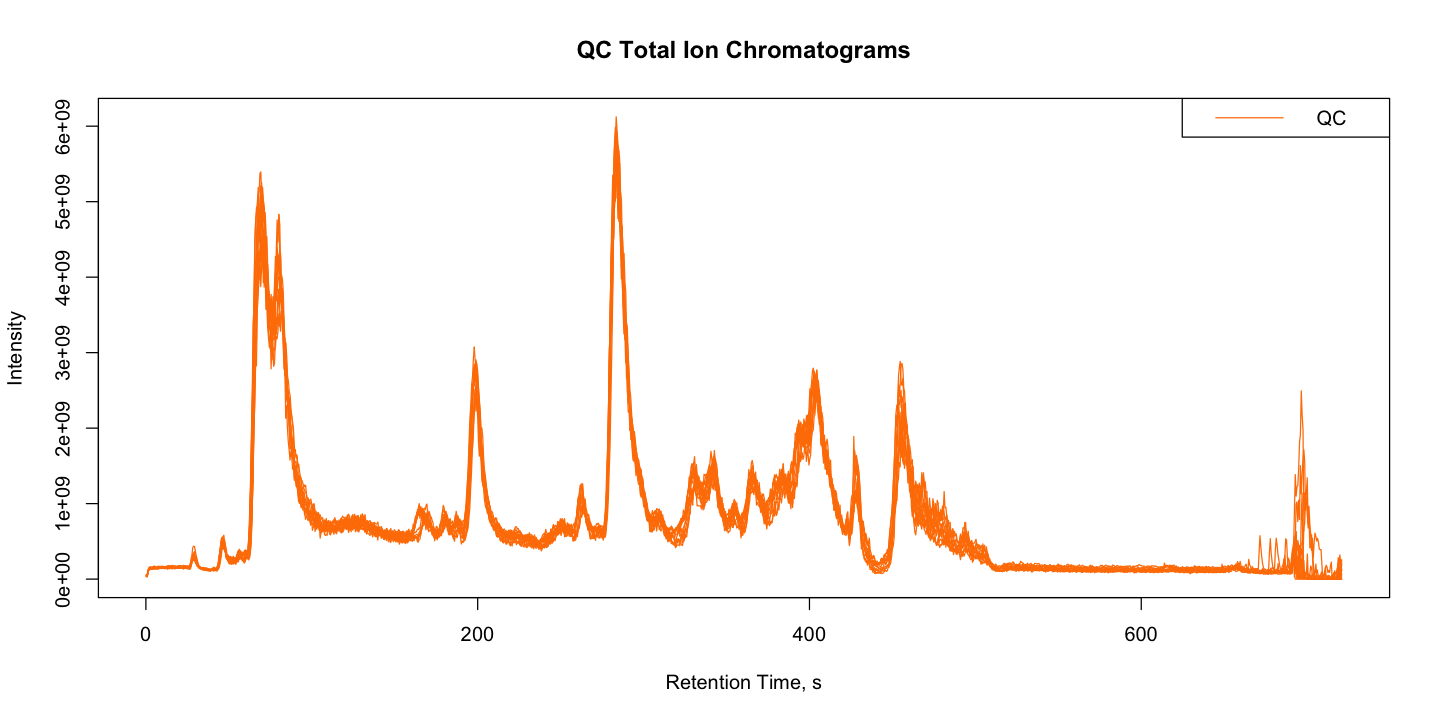

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

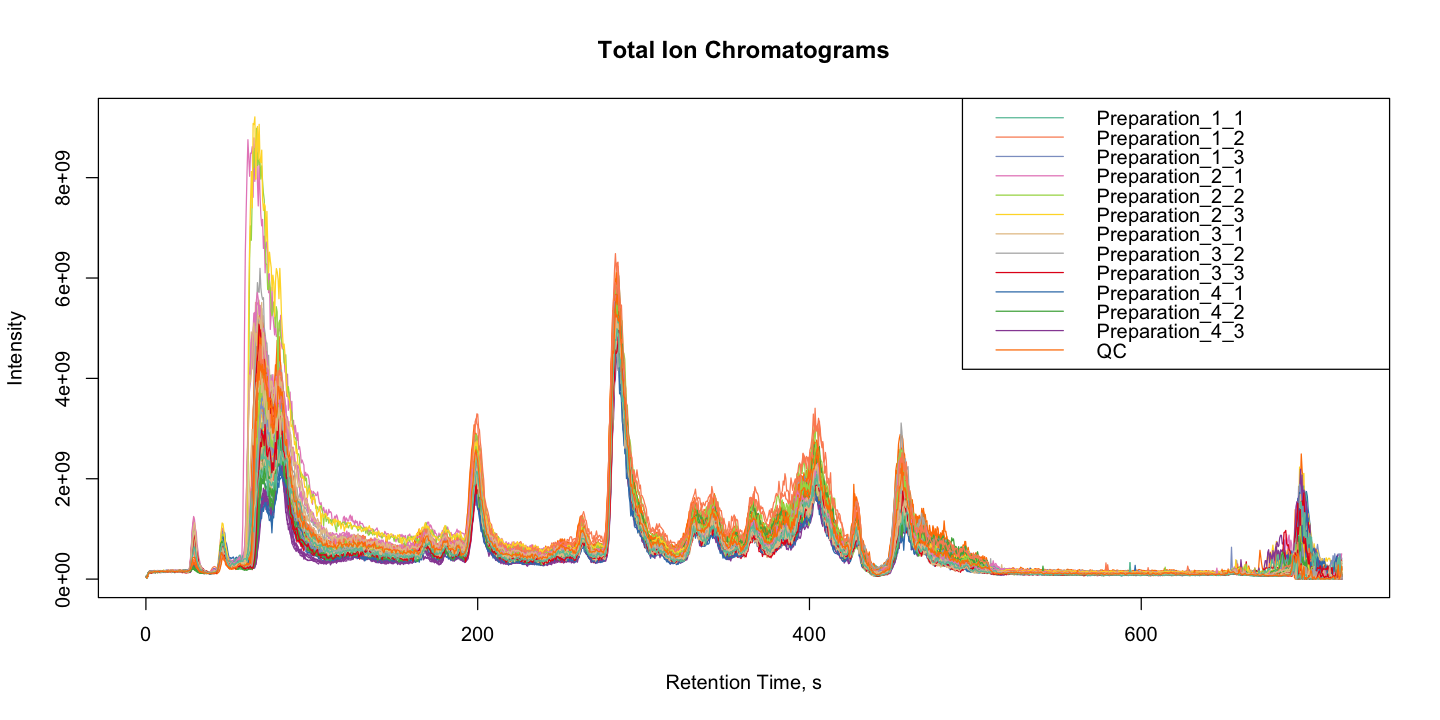

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

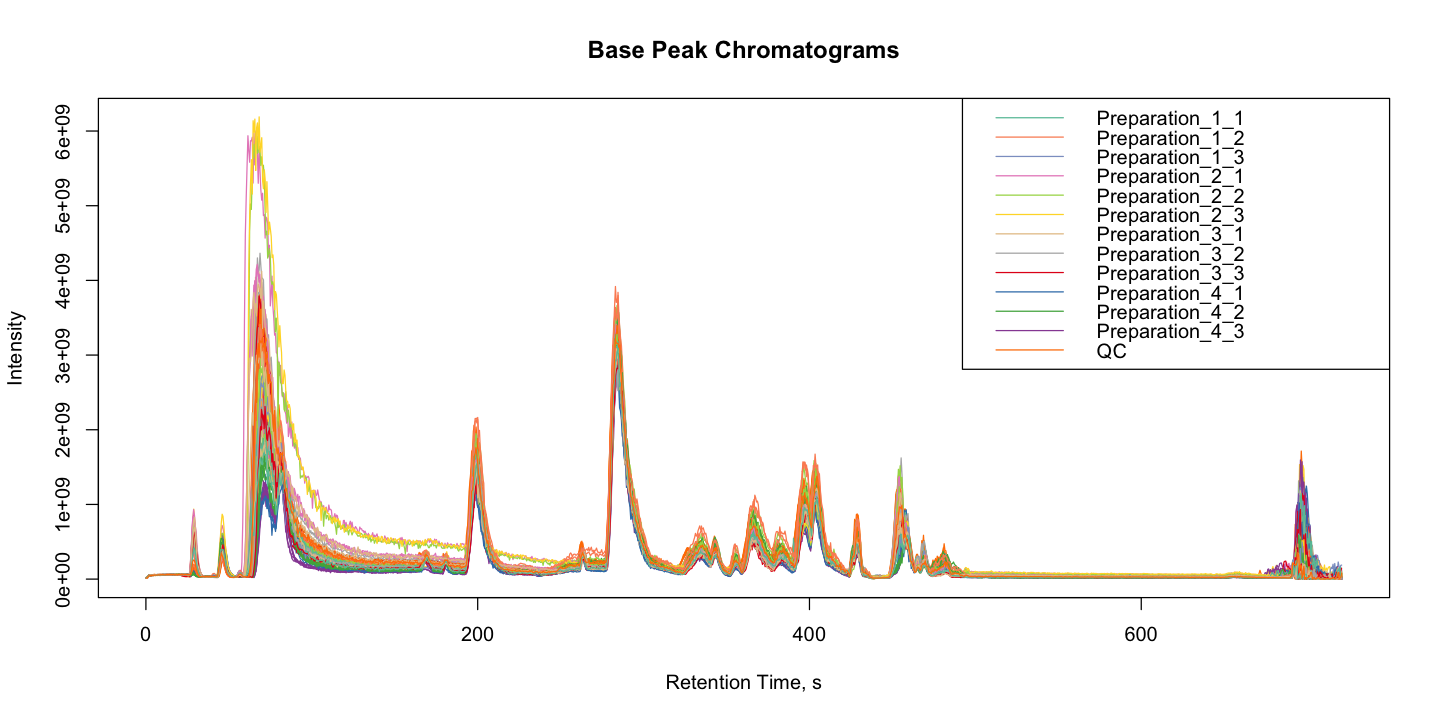

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

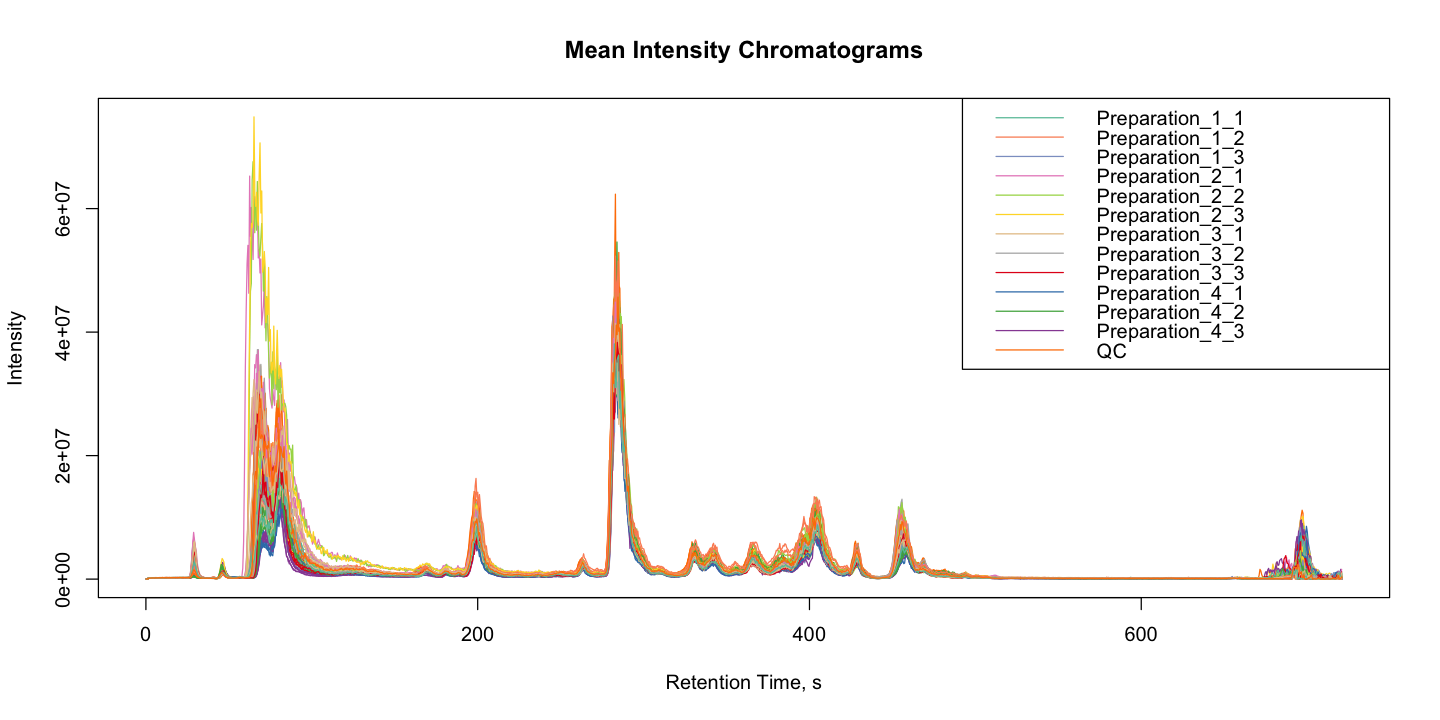

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

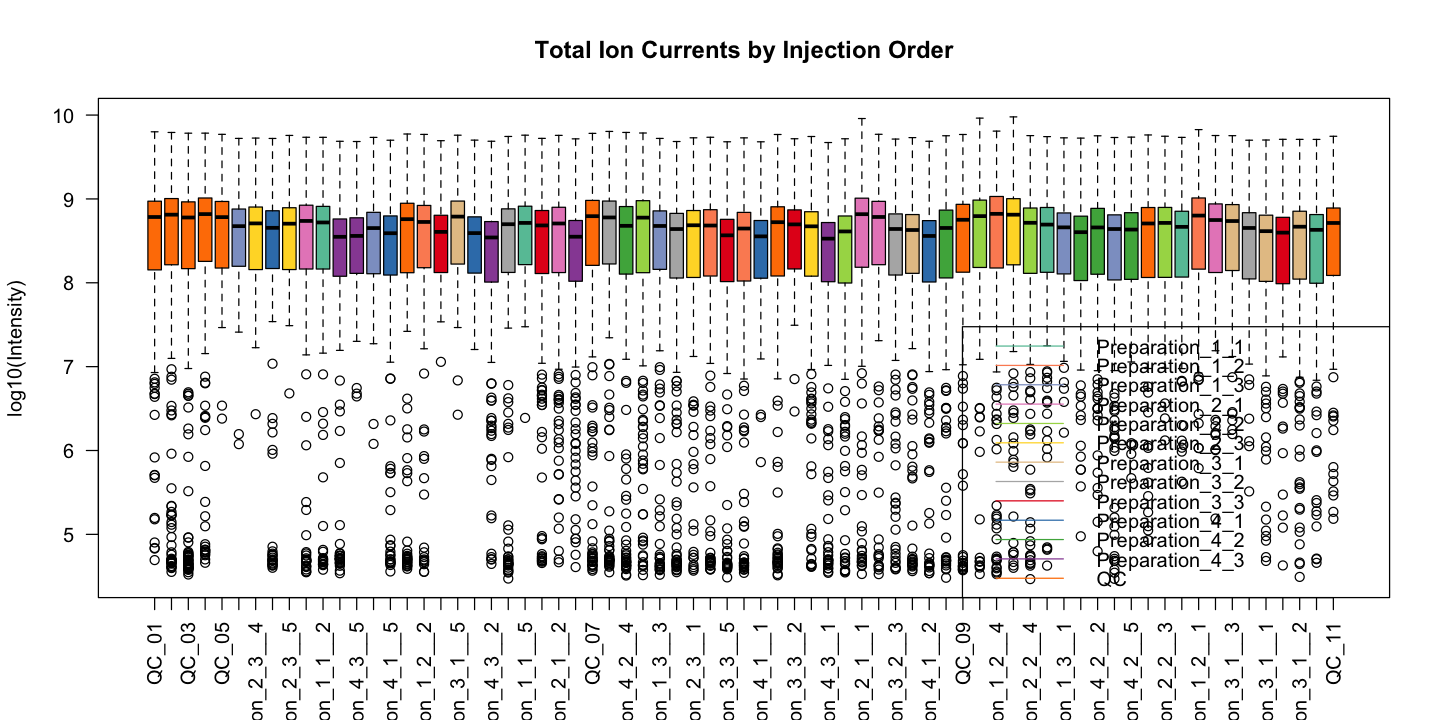

In [9]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

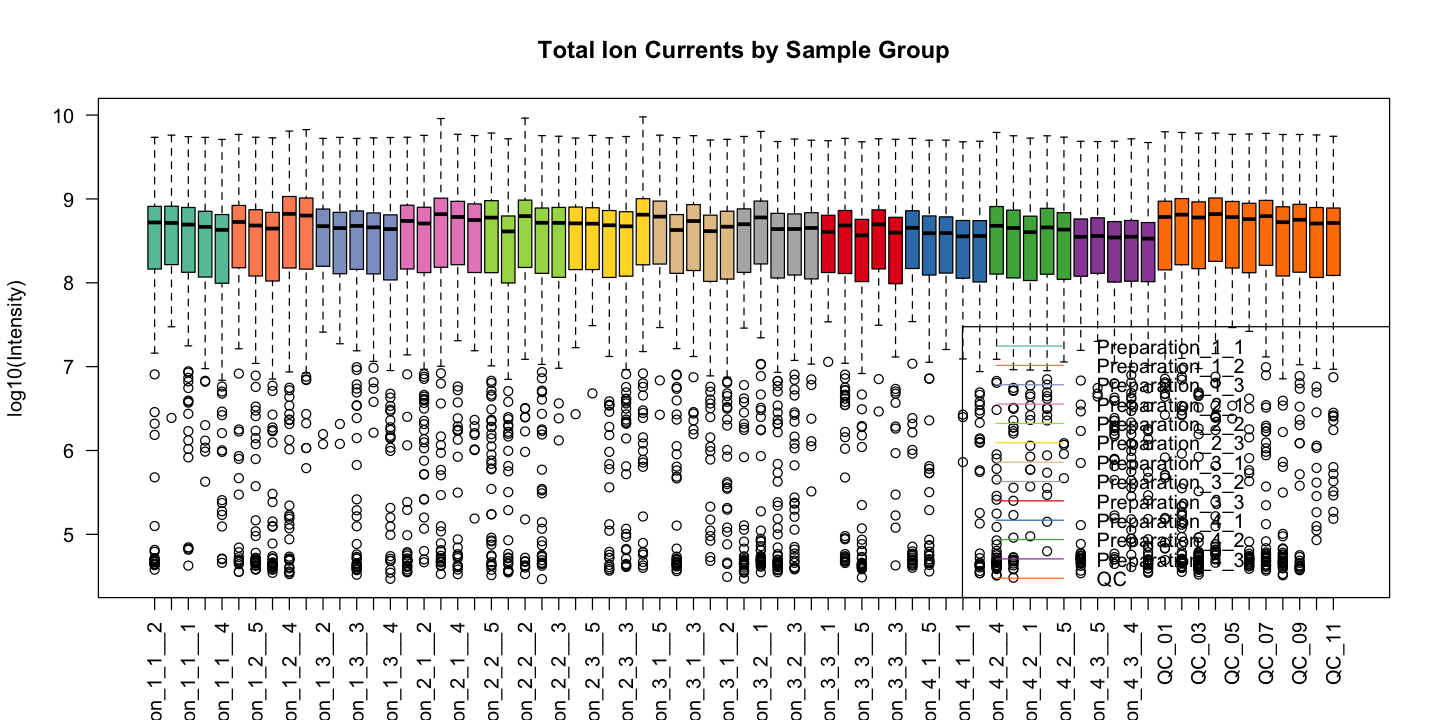

In [10]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(8.9, 85), ppm = 2.5, snthresh = 15, 
                     mzdiff = 0.074,  prefilter = c(14, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13], "60")
names(sample.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
sample.colours <- sample.colours[raw$sample_group]

### Retention Time Correction (RT)

In [13]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.0)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

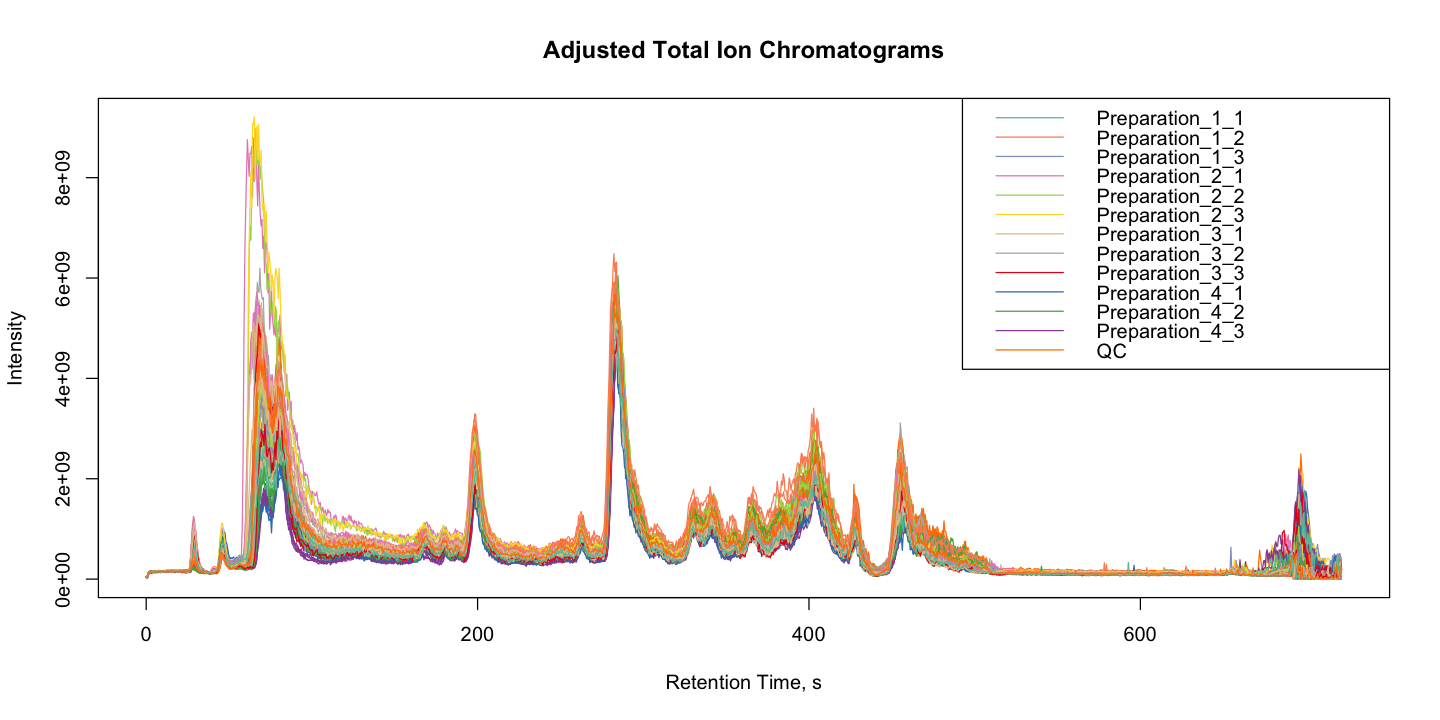

In [14]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

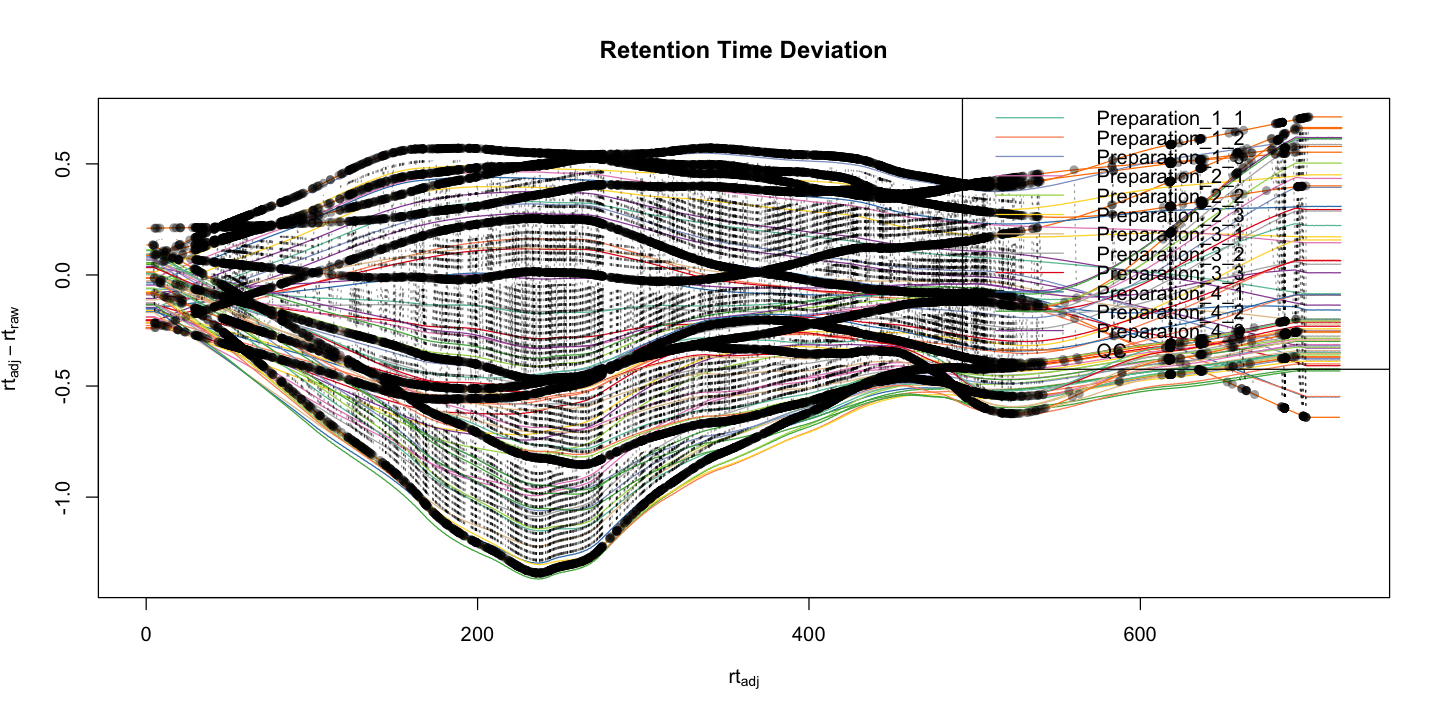

In [15]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [16]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

### Peak Filling

In [17]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [18]:
## Summarise experiment
results <- quantify(set, value = "into")

In [19]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [20]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 119 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 592 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 119 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 119 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1647 
xsAnnotate has now 1647 groups, instead of 119 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1647 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [21]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [22]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

## Normalisation to Extraction solvent

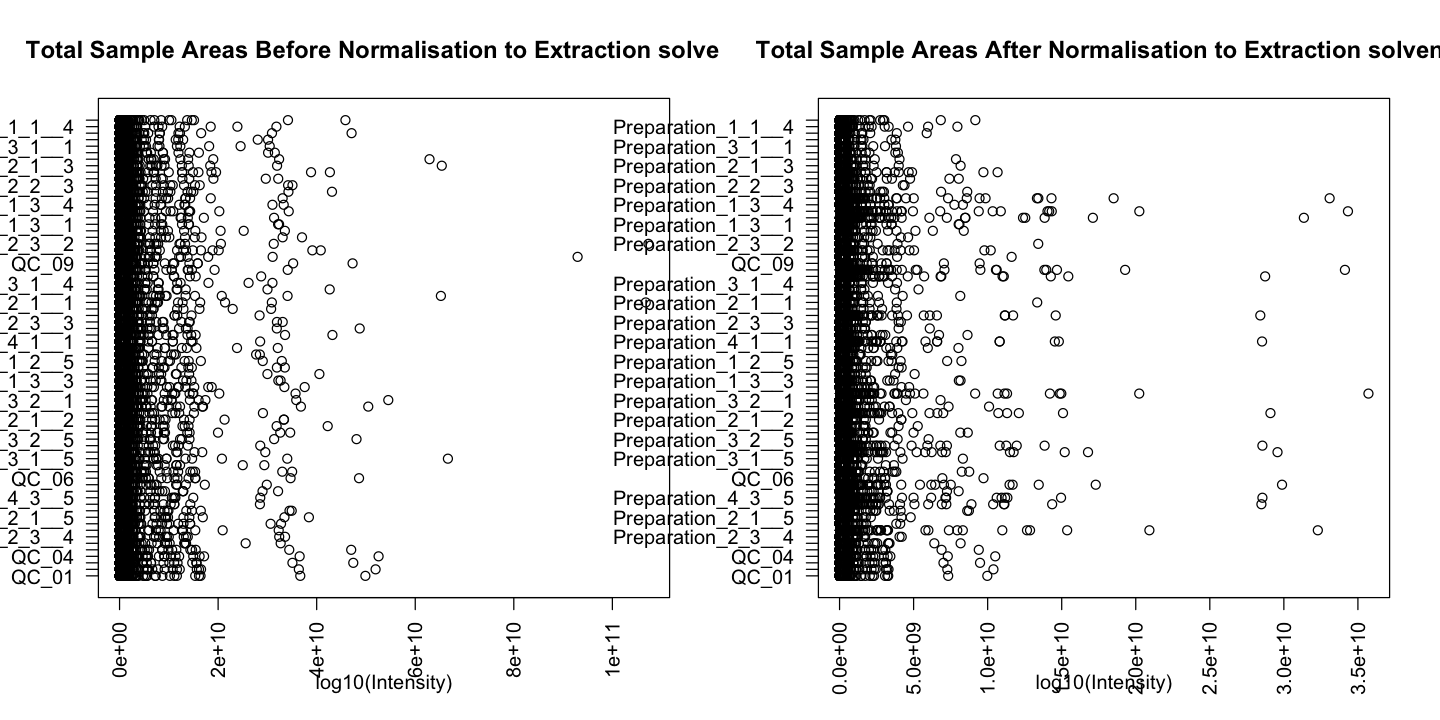

In [23]:
## Normalise data to extraction solvent
norm.weight <- function(x, weight){x / weight}

assay(results, "norm.weight") <- apply(assay(results, "raw"), 1, 
                                       norm.weight, weight = colData(results)$sample_weight) %>%
                                 t()

## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("raw") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation to Extraction solvent", las = 2)

results %>%
assay("norm.weight") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation to Extraction solvent", las = 2)

# IS Area for IS in Extraction Solvents
- Carnitine-d9: [M+H] m/z 171.1690, rt 454 sec
- Glutamic acid d3:[M+H] m/z 151.0793, rt 493 sec
- Kynurenic acid d5: [M+H] m/z 195.0813, rt 341 sec
- Lysin d3: [M+H] m/z 150.1316, rt 500 sec
- Tryptophan d5: [M+H] m/z 210.1285, rt 392 sec

Not detectable using ZicHILIC Pos:
- Hypoxanthine d4:  m/z 141.0709 (neg:139.0563), rt / sec (HILIC / sec)
- Palmitic acid d31: m/z (neg:286.4275), rt 617 sec (HILIC 52 sec)
- D-Fructose 13C6: m/z (neg:185.0762), rt 30 sec (HILIC 433 sec)
- Succinic acid d4: m/z (neg:121.0444), rt 34 sec (HILIC 464 sec)
- Prostaglandin E2 d9: m/z (neg: 360.2742), rt 343 sec (HILIC 182 sec)

In [24]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Carnitine-d9 

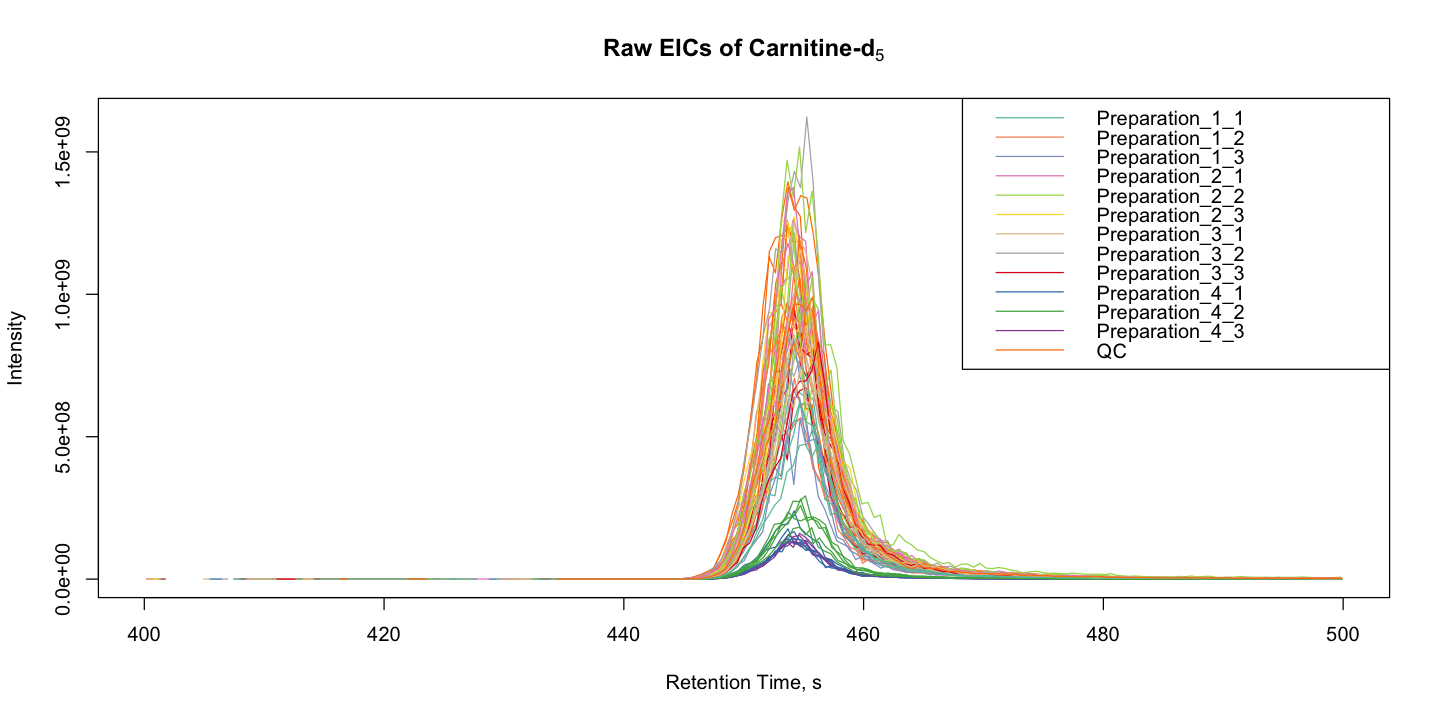

In [25]:
## Plot Carnitine-d9 before processing
card9.raw <- chromatogram(raw, mz = c(171.1685, 171.1695), rt = c(400, 500))

plot(card9.raw, col = group.colours[card9.raw$sample_group], 
     main = bquote(bold("Raw EICs of Carnitine-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [26]:
## Identify rownumber of internal standard Carnitine-d9
card9 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 171.1690, rt = 454, 5, 10)
card9 %>% head()

[1] 1000

In [27]:
peaklist <- results %>%
assay("norm.weight")
card9 <- peaklist[1000,]
area <- data.frame(card9)
extraction <- colData(results)$sample_group
card9 <- cbind(area, extraction)
card9 %>% head()

card9      extraction     
QC_01.mzXML              1469586516 QC             
QC_02.mzXML              1555002895 QC             
QC_03.mzXML              1277682783 QC             
QC_04.mzXML              1598062397 QC             
QC_05.mzXML              1131033064 QC             
Preparation_1_3__2.mzXML 1117514301 Preparation_1_3

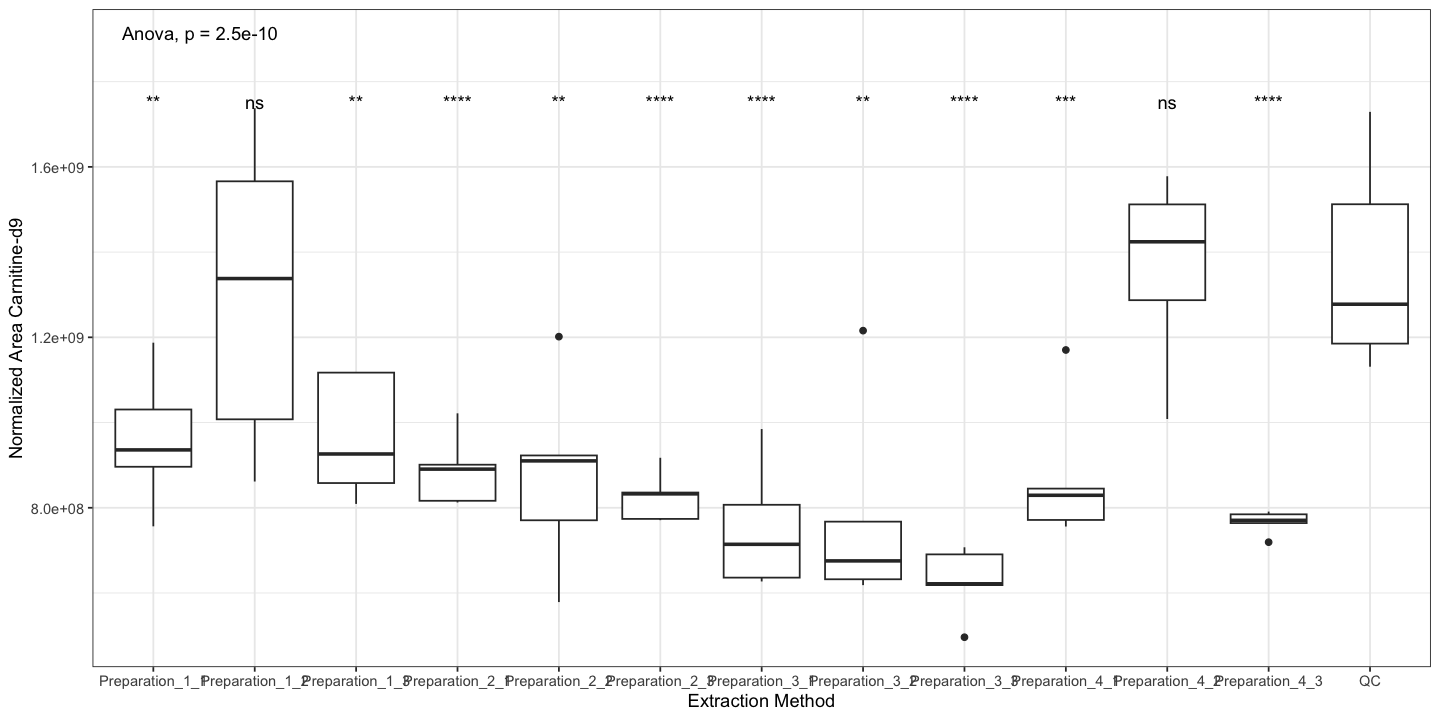

In [29]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(card9, aes(x = factor(extraction), y = card9)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 1.9e+09)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Normalized Area Carnitine-d9") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Glutamic acid d3

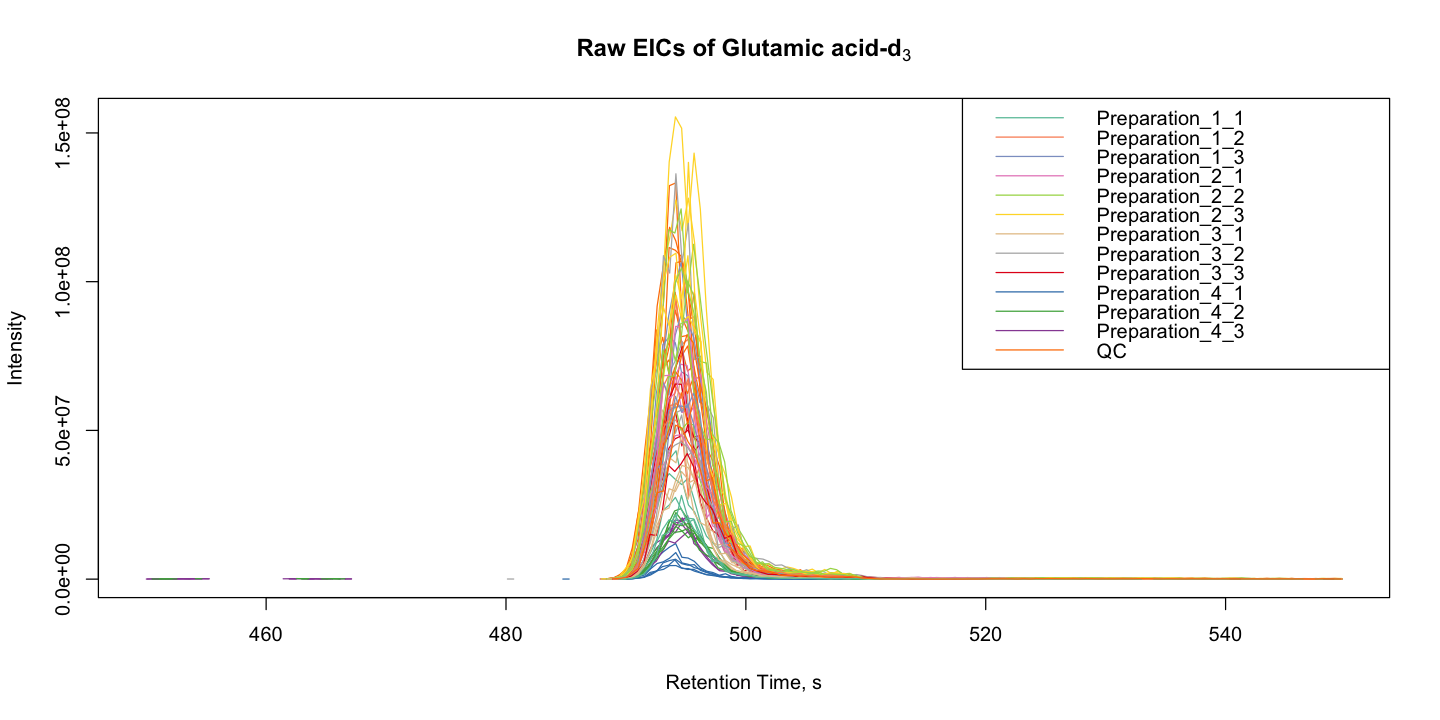

In [30]:
## Plot Glutamic acid-d3 before processing
glutd3.raw <- chromatogram(raw, mz = c(151.0788, 151.0798), rt = c(450, 550))

plot(glutd3.raw, col = group.colours[glutd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glutamic acid-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [31]:
## Identify rownumber of internal standard Glutamic acid d3
glutd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 151.0793, rt = 493, 5, 10)
glutd3 %>% head()

[1] 696

In [32]:
peaklist <- results %>%
assay("norm.weight")
glutd3 <- peaklist[696,]
area <- data.frame(glutd3)
extraction <- colData(results)$sample_group
glutd3 <- cbind(area, extraction)
glutd3 %>% head()

glutd3    extraction     
QC_01.mzXML              103758309 QC             
QC_02.mzXML              115697963 QC             
QC_03.mzXML               91769947 QC             
QC_04.mzXML              109595553 QC             
QC_05.mzXML               84817468 QC             
Preparation_1_3__2.mzXML 120583726 Preparation_1_3

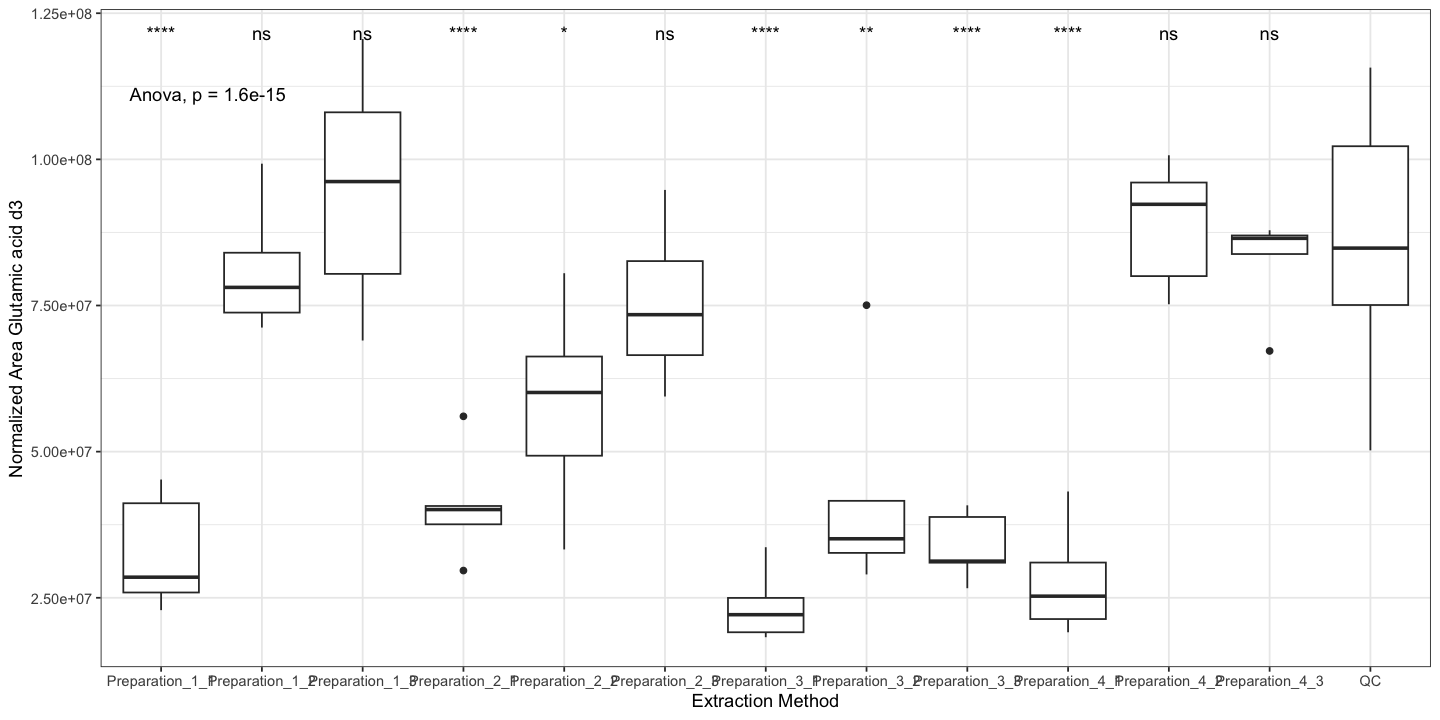

In [33]:
## Plot Area of IS of all extractions
ggplot(glutd3, aes(x = factor(extraction), y = glutd3)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 1.1e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Normalized Area Glutamic acid d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

###  Kynurenic acid d5

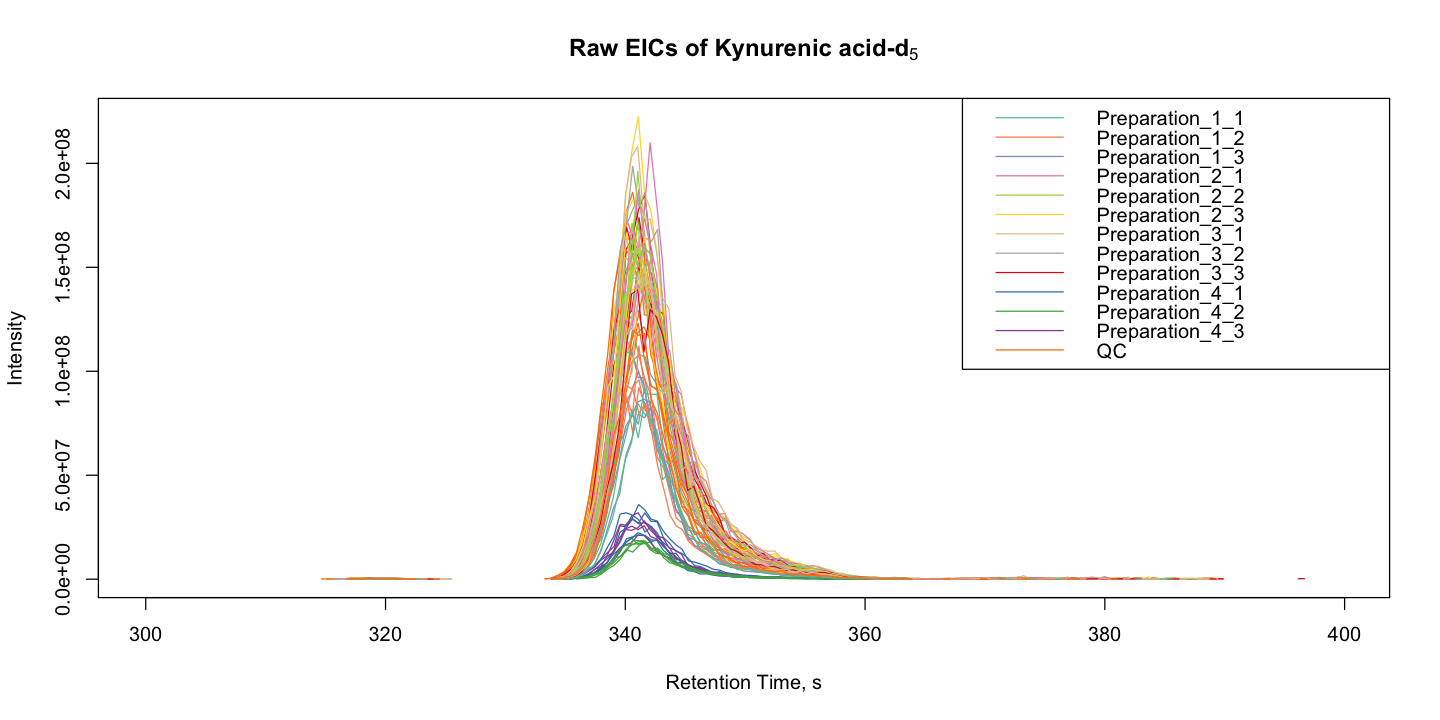

In [34]:
## Plot Kynurenic acid d5 before processing
kynd5.raw <- chromatogram(raw, mz = c(195.0808, 195.0818), rt = c(300, 400))

plot(kynd5.raw, col = group.colours[kynd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Kynurenic acid-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [35]:
## Identify rownumber of internal standard Kynurenic acid d5 
kynd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 195.0813, rt = 341, 5, 10)
kynd5 %>% head()

[1] 1378

In [36]:
peaklist <- results %>%
assay("norm.weight")
kynd5 <- peaklist[1378,]
area <- data.frame(kynd5)
extraction <- colData(results)$sample_group
kynd5 <- cbind(area, extraction)
kynd5 %>% head()

kynd5     extraction     
QC_01.mzXML              226241177 QC             
QC_02.mzXML              230411992 QC             
QC_03.mzXML              201928902 QC             
QC_04.mzXML              214650254 QC             
QC_05.mzXML              196803224 QC             
Preparation_1_3__2.mzXML 192699730 Preparation_1_3

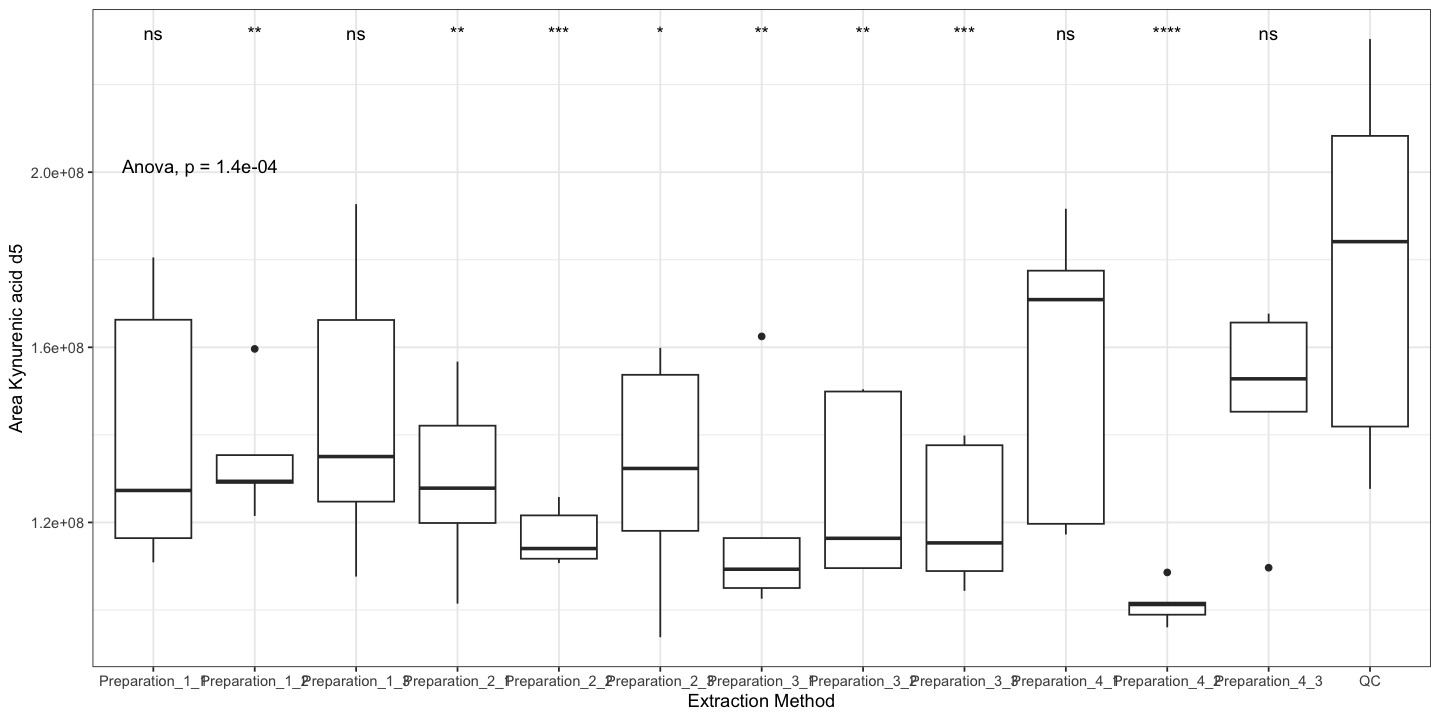

In [37]:
## Plot Area of IS of all extractions
ggplot(kynd5, aes(x = factor(extraction), y = kynd5)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 2.0e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Kynurenic acid d5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Lysin d3

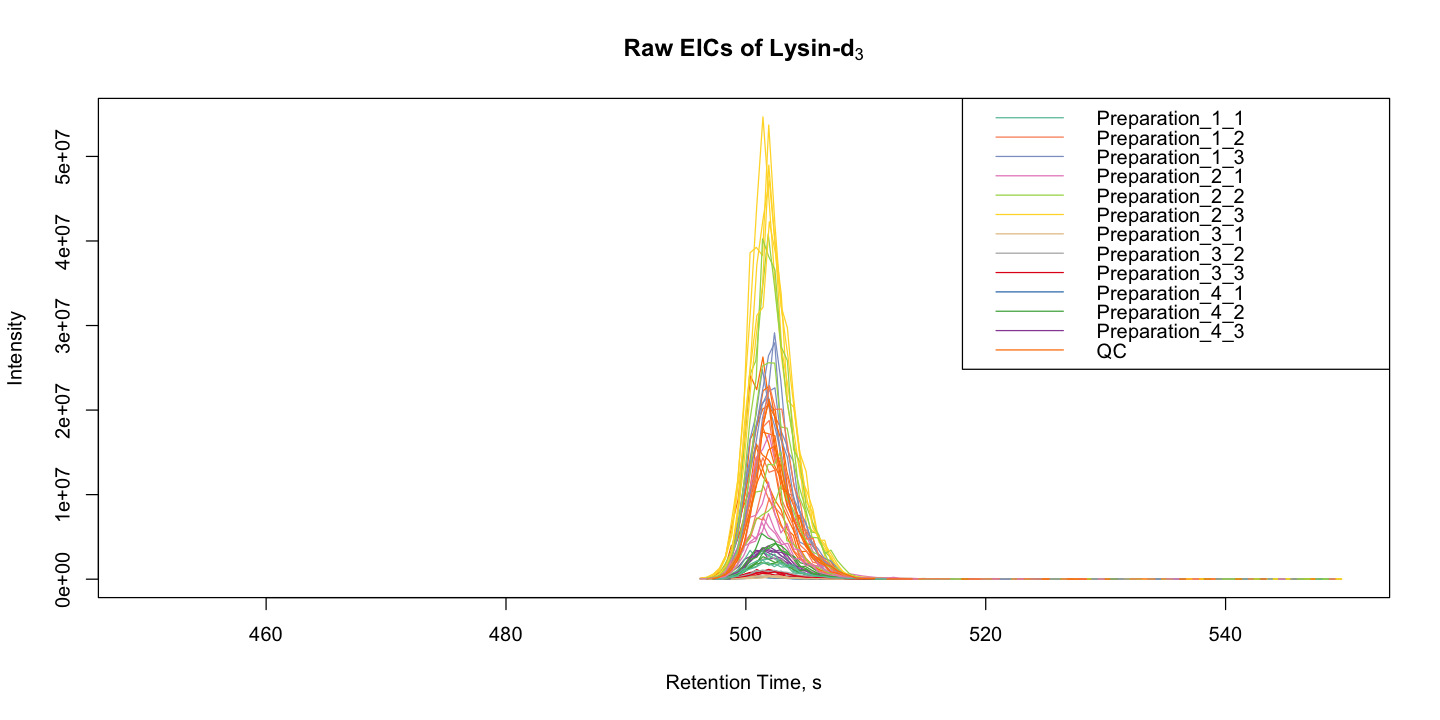

In [38]:
## Plot Lysin d3 before processing
lysd3.raw <- chromatogram(raw, mz = c(150.1310, 150.1330), rt = c(450, 550))

plot(lysd3.raw, col = group.colours[lysd3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Lysin-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [39]:
## Identify rownumber of internal standard Lysin d3
lysd3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 150.1316, rt = 500, 5, 10)
lysd3 %>% head()

[1] 682

In [40]:
peaklist <- results %>%
assay("norm.weight")
lysd3 <- peaklist[682,]
area <- data.frame(lysd3)
extraction <- colData(results)$sample_group
lysd3 <- cbind(area, extraction)
lysd3 %>% head()

lysd3    extraction     
QC_01.mzXML              13012512 QC             
QC_02.mzXML              20584697 QC             
QC_03.mzXML              10821153 QC             
QC_04.mzXML              15700226 QC             
QC_05.mzXML              10663121 QC             
Preparation_1_3__2.mzXML 21441938 Preparation_1_3

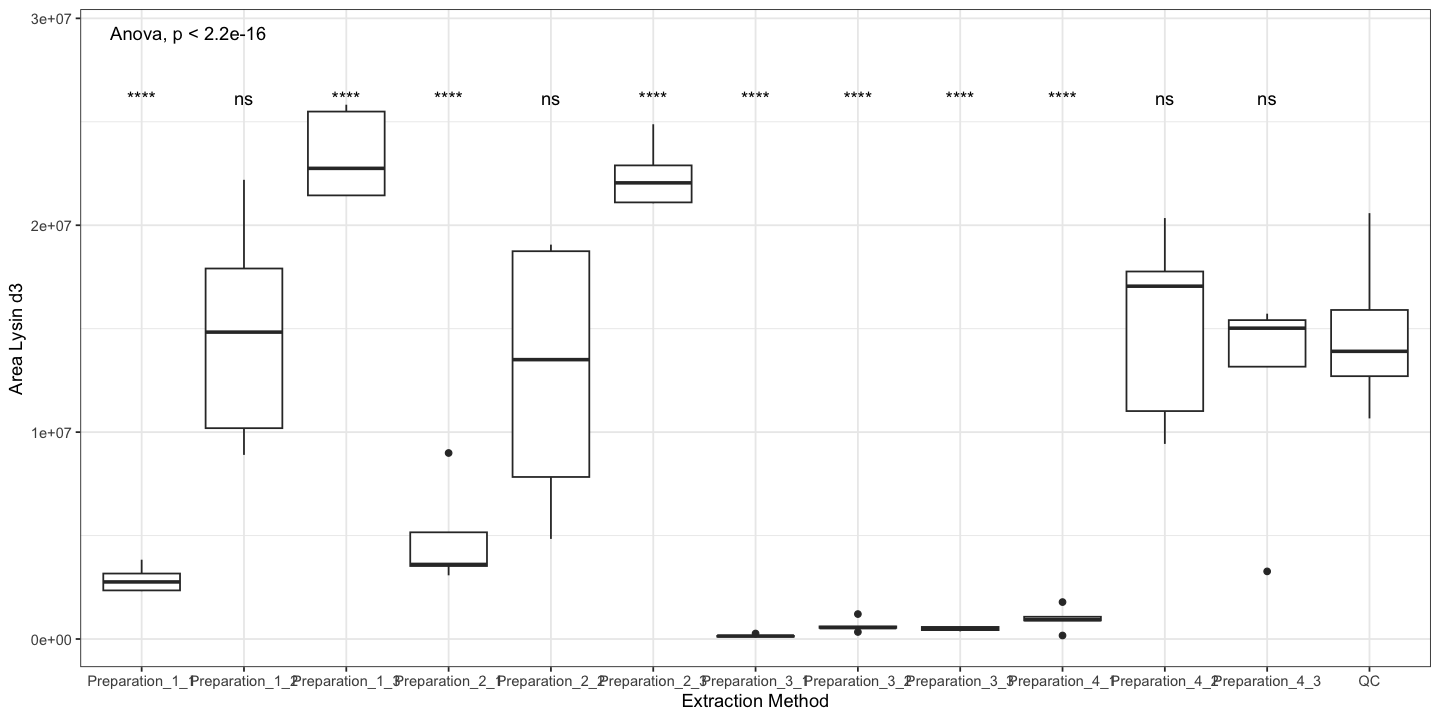

In [41]:
## Plot Area of IS of all extractions
ggplot(lysd3, aes(x = factor(extraction), y = lysd3)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 2.9e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Lysin d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Trp-d5

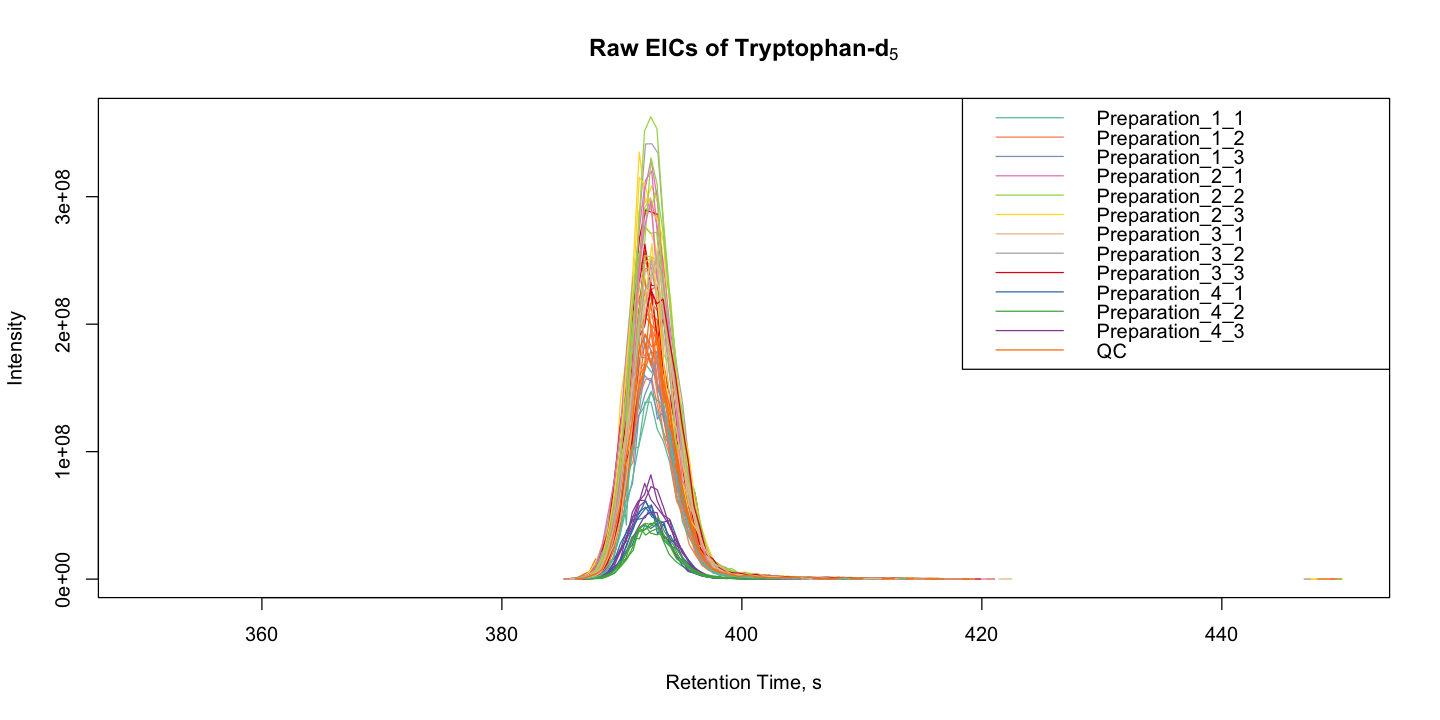

In [42]:
## Plot Lysin d3 before processing
trpd5.raw <- chromatogram(raw, mz = c(210.1280, 210.1290), rt = c(350, 450))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [43]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 210.1285, rt = 392, 5, 10)
trpd5 %>% head()

[1] 1607

In [44]:
peaklist <- results %>%
assay("norm.weight")
trpd5 <- peaklist[1607,]
area <- data.frame(trpd5)
extraction <- colData(results)$sample_group
trpd5 <- cbind(area, extraction)
trpd5 %>% head()

trpd5     extraction     
QC_01.mzXML              214675602 QC             
QC_02.mzXML              207658487 QC             
QC_03.mzXML              194532577 QC             
QC_04.mzXML              198416957 QC             
QC_05.mzXML              201035961 QC             
Preparation_1_3__2.mzXML 226444092 Preparation_1_3

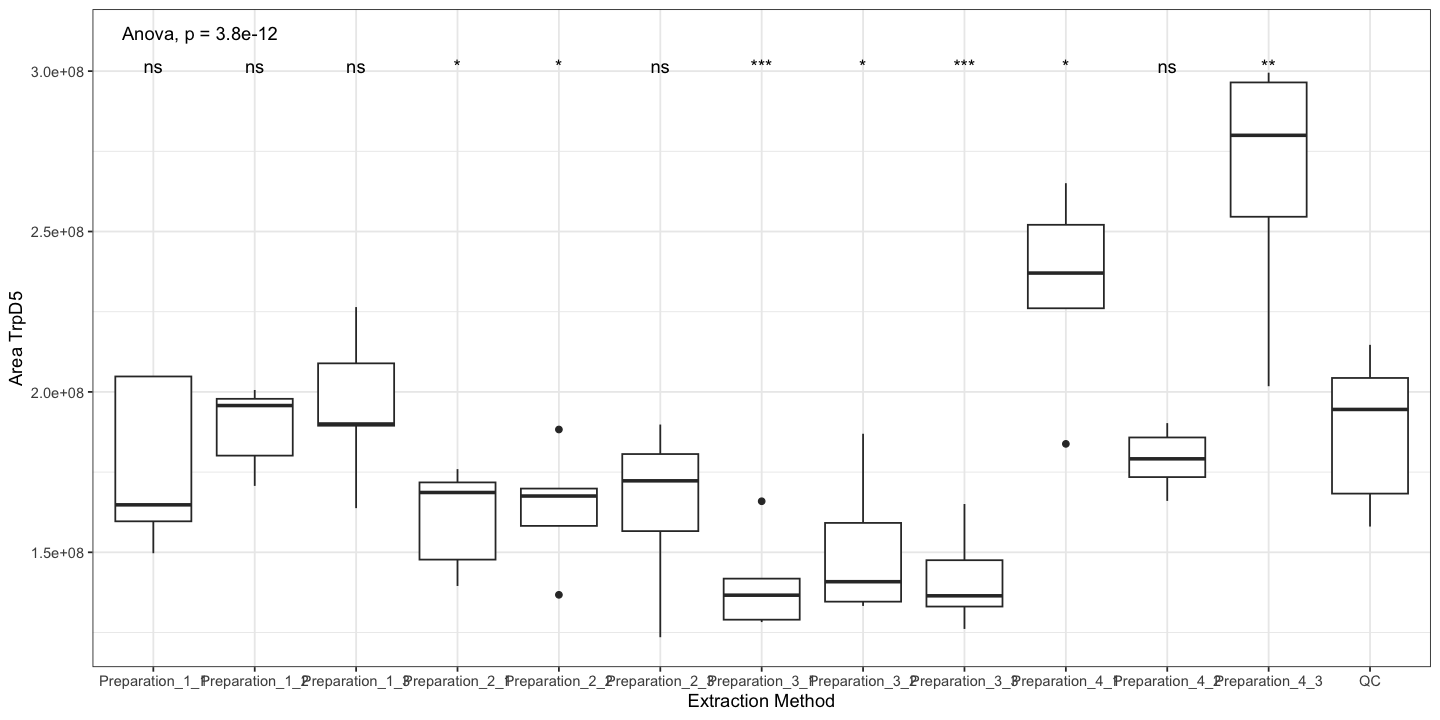

In [45]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(trpd5, aes(x = factor(extraction), y = trpd5)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 3.1e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area TrpD5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

## IS Area for IS in Reconstitution Solvent 

Positive:
- Arginine d7: m/z 182.1629, rt 28 sec (HILIC 500 sec)
- not detected: Aspartic acid d3: m/z 137.0636, rt 28 sec (HILIC 498 sec)
- Creatinine d3: m/z 117.0850, rt 30 sec (HILIC 285 sec)
- Cytosine d2: m/z 114.0631, rt 30 sec (HILIC 329 sec)
- not detected: Glycin N15: m/z 77.0363 (neg:75.0218), rt / sec (HILIC / sec)
- Thymidine d4: m/z 247.1227, rt 0 sec (HILIC 198 sec)

Negative:
- Arginine d7: m/z 180.1483, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 135.0491, rt 28 sec (HILIC 498 sec)
- Cortisol d4: m/z 365.2271, rt 598 sec (HILIC / sec)
- Glucose d7: m/z 186.1000, rt 29 sec (HILIC 456 sec)
- Stearic acid 13C: m/z 284.2676, rt / sec (HILIC 69 sec)
- Thymidine d4: m/z 245.1081, rt 0 sec (HILIC 198 sec)

### Arginin d7

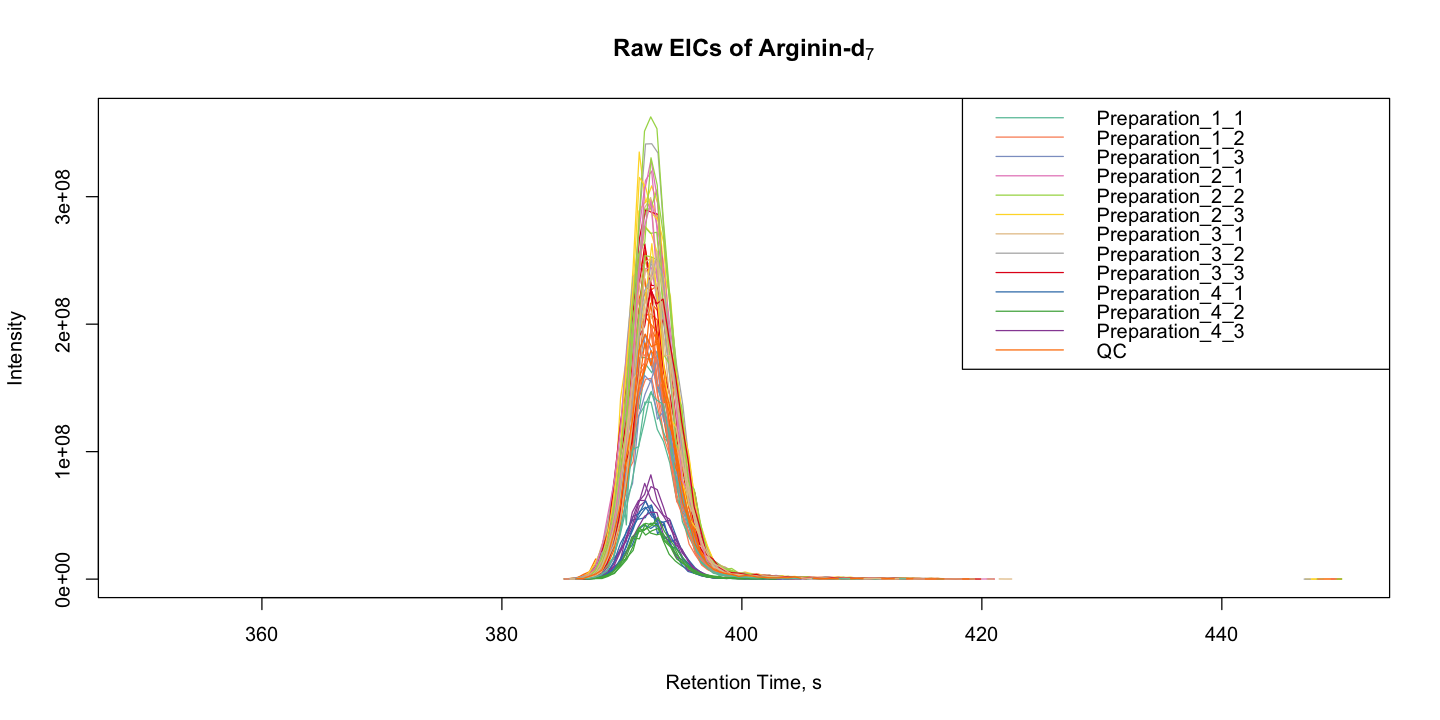

In [46]:
## Plot Lysin d3 before processing
argd7.raw <- chromatogram(raw, mz = c(182.1620, 182.1630), rt = c(450, 500))

plot(trpd5.raw, col = group.colours[argd7.raw$sample_group], 
     main = bquote(bold("Raw EICs of Arginin-d"[7])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [47]:
## Identify rownumber of internal standard tryptophan-d5
argd7 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 182.1629, rt = 500, 5, 10)
argd7 %>% head()

[1] 1174

In [48]:
peaklist <- results %>%
assay("raw")
argd7 <- peaklist[1174,]
area <- data.frame(argd7)
extraction <- colData(results)$sample_group
argd7 <- cbind(area, extraction)
argd7 %>% head()

argd7     extraction     
QC_01.mzXML               77406825 QC             
QC_02.mzXML              116281035 QC             
QC_03.mzXML               68569995 QC             
QC_04.mzXML               88254711 QC             
QC_05.mzXML               65377195 QC             
Preparation_1_3__2.mzXML  69263886 Preparation_1_3

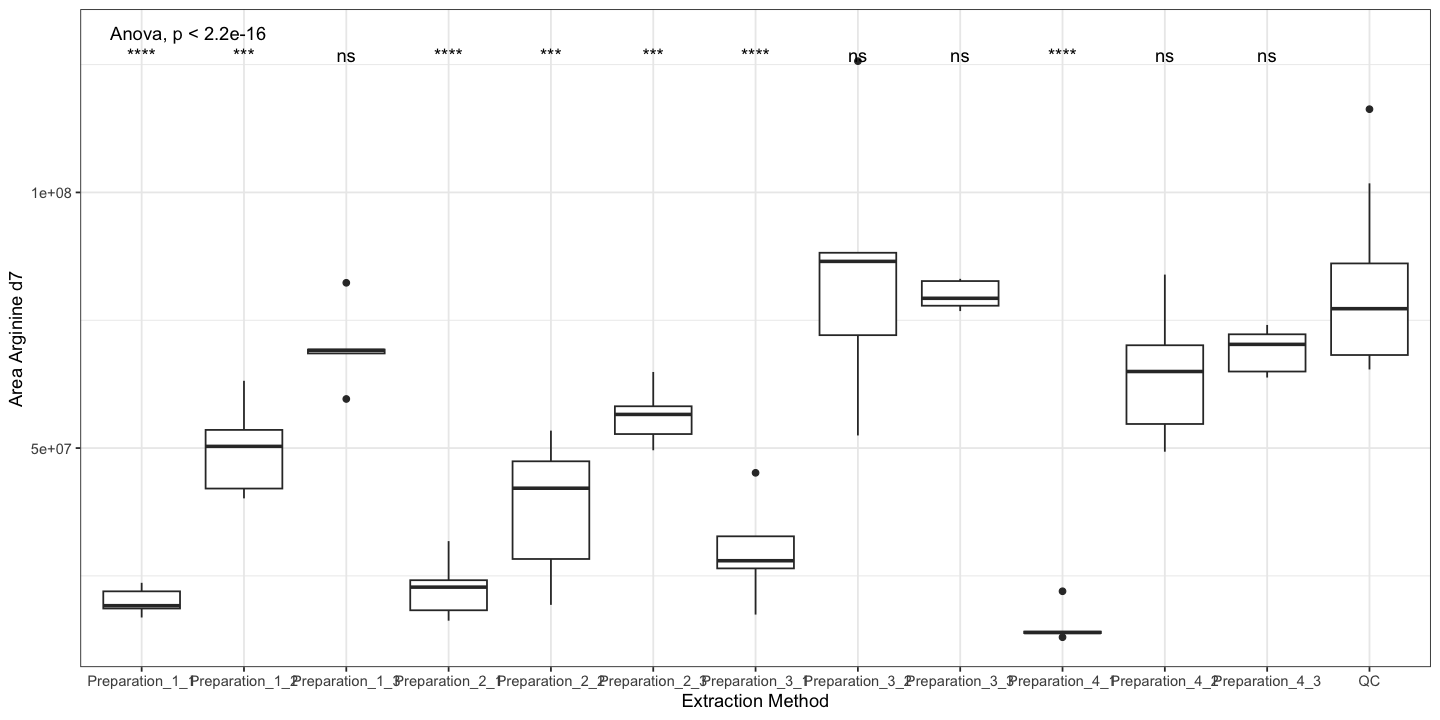

In [49]:
## Plot Area IS of all extractions
ggplot(argd7, aes(x = factor(extraction), y = argd7)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 1.3e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Arginine d7") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Creatinine-d3

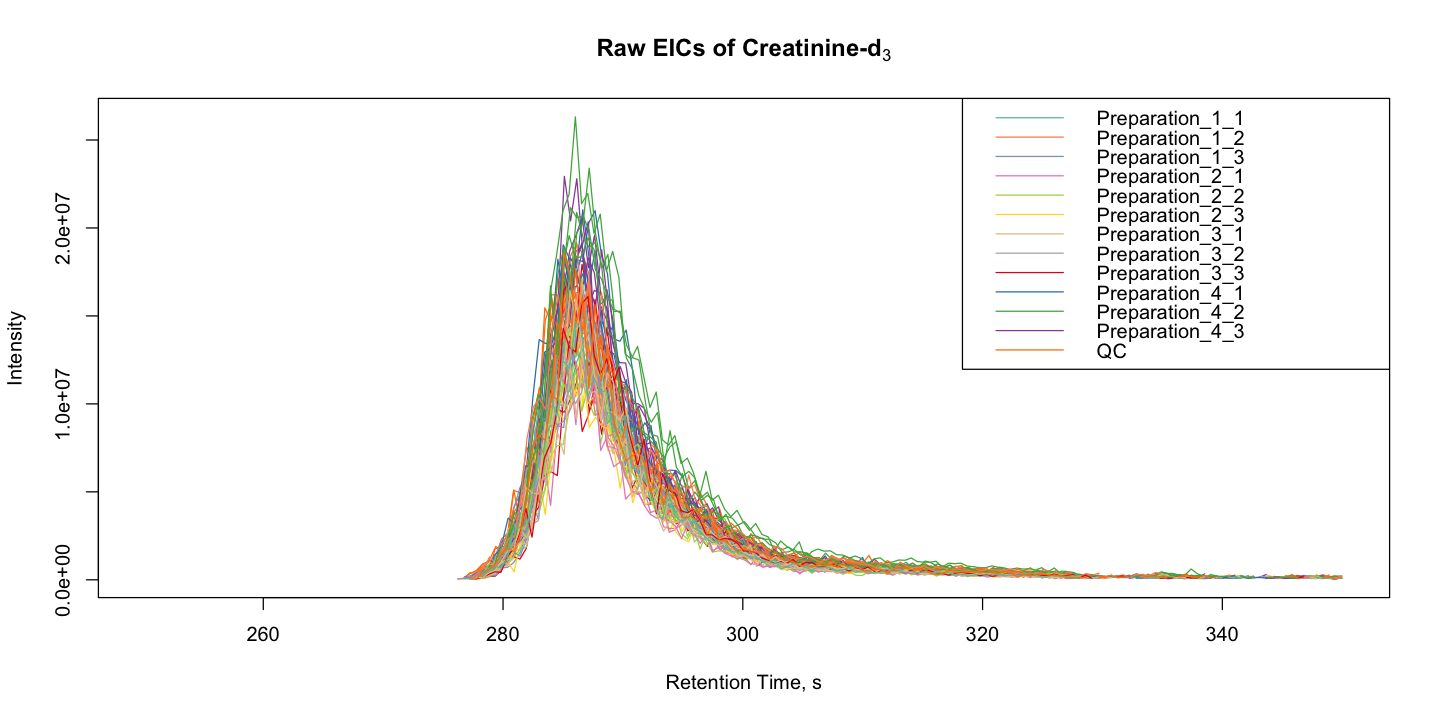

In [50]:
## Plot Lysin d3 before processing
cread3.raw <- chromatogram(raw, mz = c(117.0840, 117.0860), rt = c(250, 350))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [51]:
## Identify rownumber of internal standard tryptophan-d5
cread3 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 117.0850, rt = 285, 5, 10)
cread3 %>% head()

[1] 300

In [52]:
peaklist <- results %>%
assay("raw")
cread3 <- peaklist[300,]
area <- data.frame(cread3)
extraction <- colData(results)$sample_group
cread3 <- cbind(area, extraction)
cread3 %>% head()

cread3    extraction     
QC_01.mzXML              154562264 QC             
QC_02.mzXML              159797579 QC             
QC_03.mzXML              147769006 QC             
QC_04.mzXML              152755282 QC             
QC_05.mzXML              146316173 QC             
Preparation_1_3__2.mzXML 146303104 Preparation_1_3

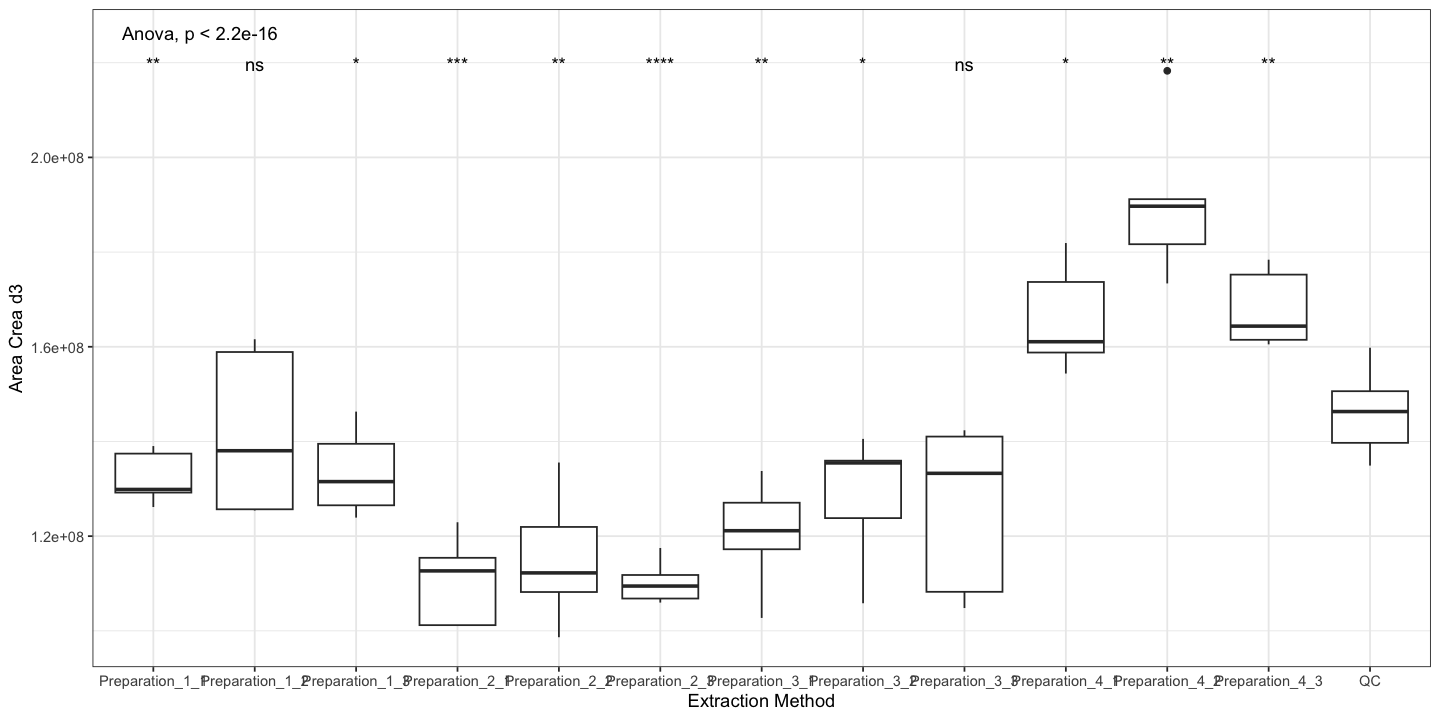

In [53]:
## Plot Area IS of all extractions
ggplot(cread3, aes(x = factor(extraction), y = cread3)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 2.25e+08)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Crea d3") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Cytosine d2

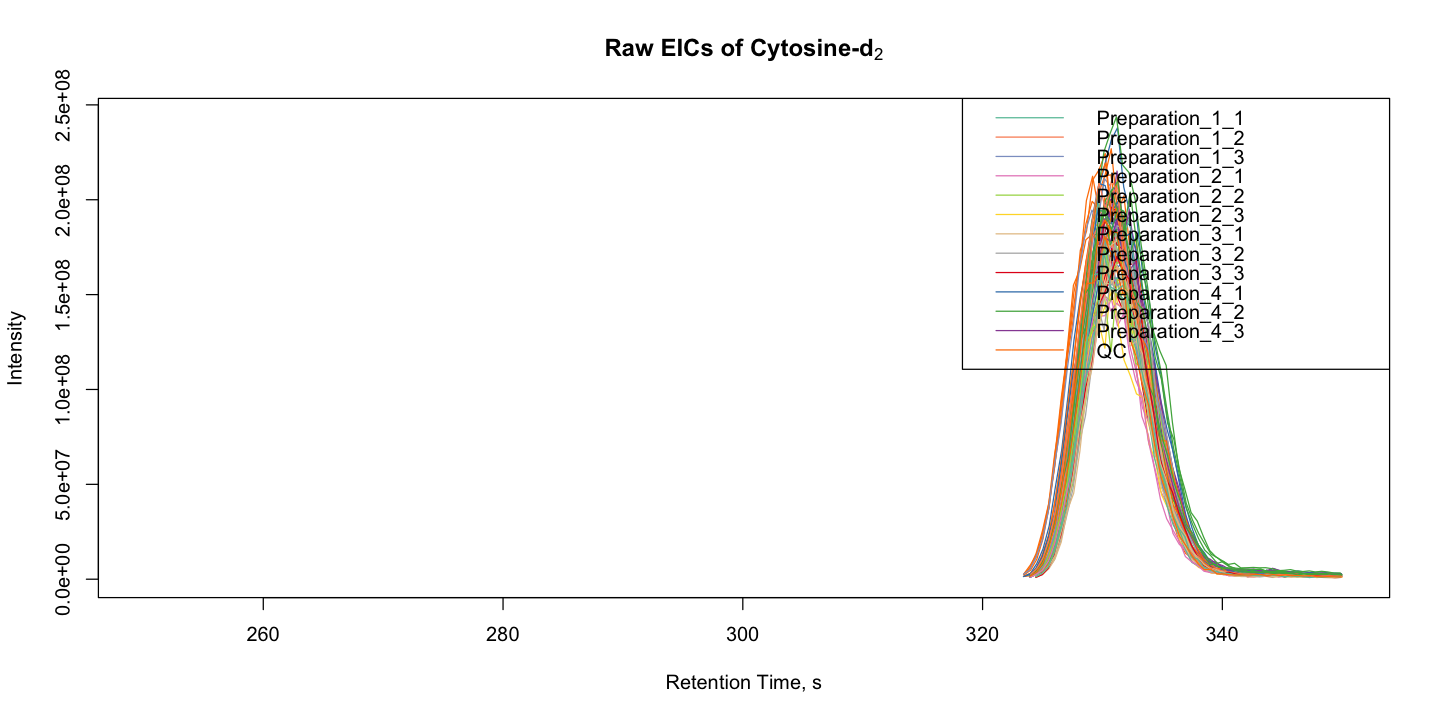

In [54]:
## Plot Lysin d3 before processing
cytd2.raw <- chromatogram(raw, mz = c(114.0620, 114.0650), rt = c(250, 350))

plot(cytd2.raw, col = group.colours[cytd2.raw$sample_group], 
     main = bquote(bold("Raw EICs of Cytosine-d"[2])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [55]:
## Identify rownumber of internal standard tryptophan-d5
cytd2 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0631, rt = 329, 5, 10)
cytd2 %>% head()

[1] 269

In [56]:
peaklist <- results %>%
assay("raw")
cytd2 <- peaklist[269,]
area <- data.frame(cytd2)
extraction <- colData(results)$sample_group
cytd2 <- cbind(area, extraction)
cytd2 %>% head()

cytd2      extraction     
QC_01.mzXML                77888883 QC             
QC_02.mzXML              1584002977 QC             
QC_03.mzXML              1469687211 QC             
QC_04.mzXML              1560225254 QC             
QC_05.mzXML              1423565210 QC             
Preparation_1_3__2.mzXML 1424820352 Preparation_1_3

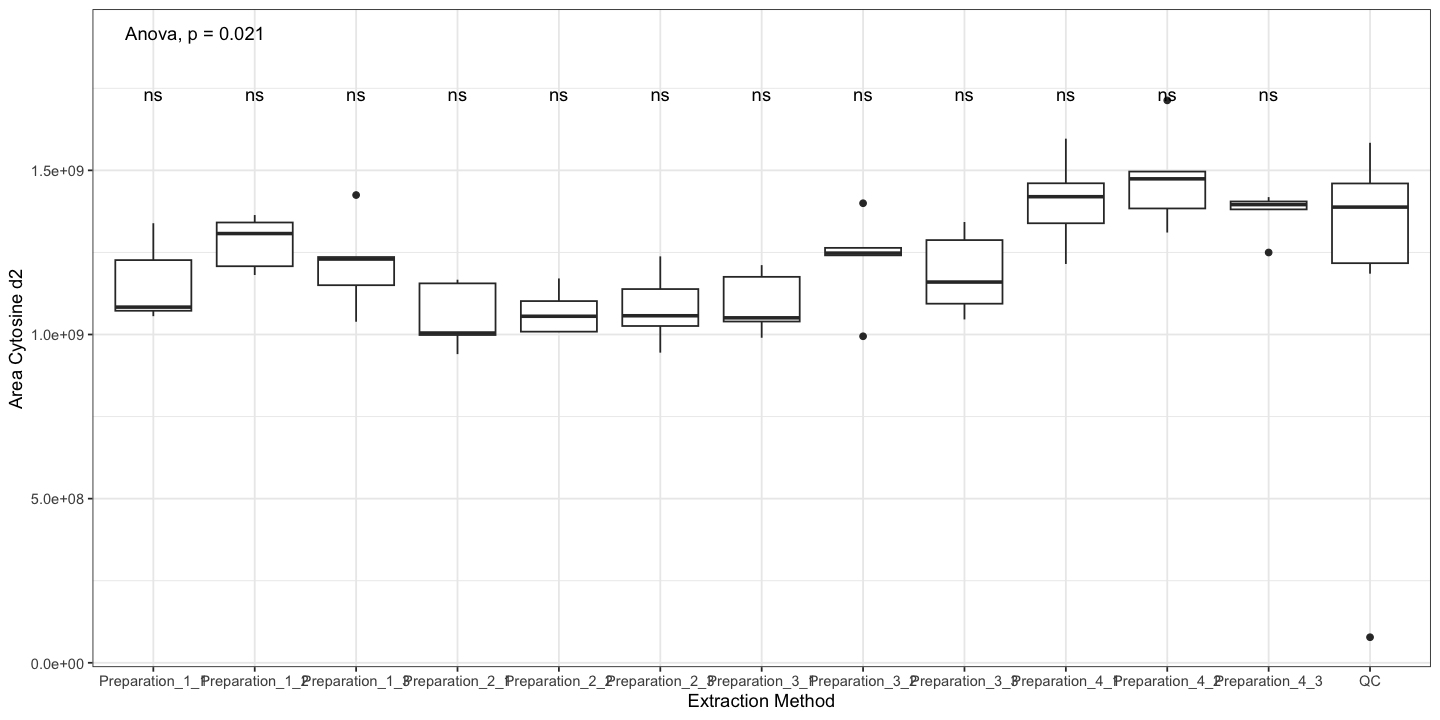

In [57]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(cytd2, aes(x = factor(extraction), y = cytd2)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 1.9e+09)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Cytosine d2") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Thymidine d4

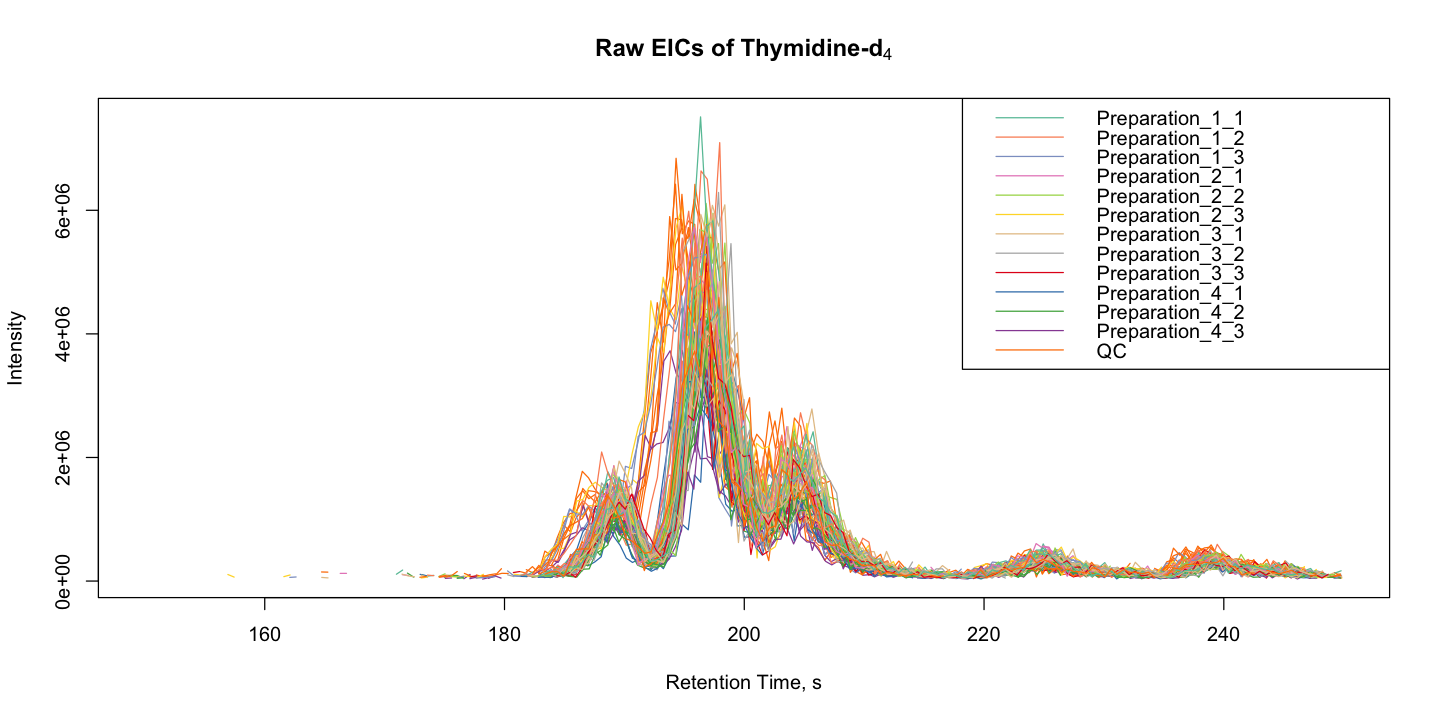

In [58]:
## Plot Lysin d3 before processing
thyd4.raw <- chromatogram(raw, mz = c(247.1530, 247.1560), rt = c(150, 250))

plot(thyd4.raw, col = group.colours[thyd4.raw$sample_group], 
     main = bquote(bold("Raw EICs of Thymidine-d"[4])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [59]:
## Identify rownumber of internal standard tryptophan-d5
thymd4 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 247.1540, rt = 198, 5, 10)
thymd4 %>% head()

[1] 2221

In [60]:
peaklist <- results %>%
assay("raw")
thymd4 <- peaklist[2221,]
area <- data.frame(thymd4)
extraction <- colData(results)$sample_group
thymd4 <- cbind(area, extraction)
thymd4 %>% head()

thymd4   extraction     
QC_01.mzXML              52217303 QC             
QC_02.mzXML              53062445 QC             
QC_03.mzXML              47604986 QC             
QC_04.mzXML              51276750 QC             
QC_05.mzXML              49135721 QC             
Preparation_1_3__2.mzXML 43378284 Preparation_1_3

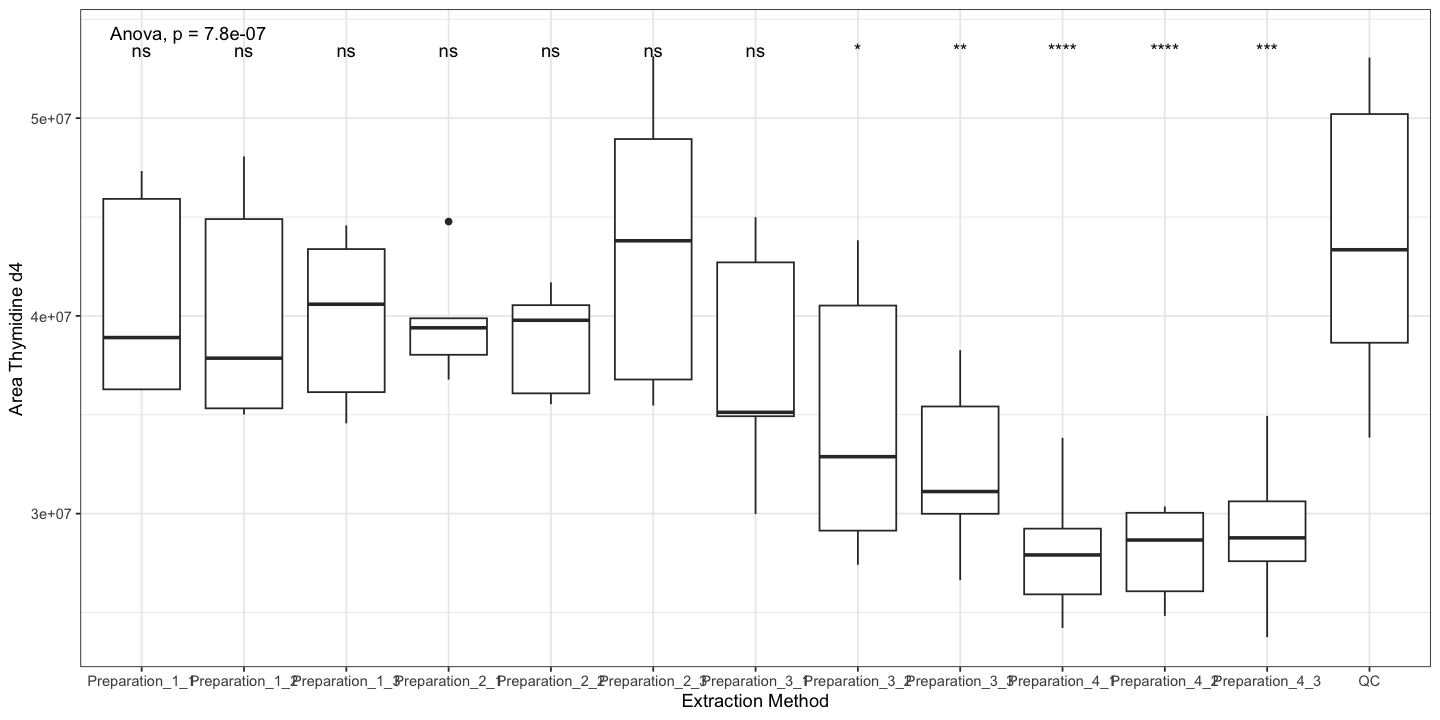

In [61]:
## Plot Area IS of all extractions
ggplot(thymd4, aes(x = factor(extraction), y = thymd4)) +
  geom_boxplot(aes(group = extraction),) +
  stat_compare_means(method = "anova", label.y = 5.4e+07)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Extraction Method") +
  ylab("Area Thymidine d4") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

In [62]:
write_xlsx(list(card9 = as.data.frame(card9), 
                glutd3 = as.data.frame(glutd3), 
                trpd5 = as.data.frame(trpd5),
                kynd5 = as.data.frame(kynd5),
                lysd3 = as.data.frame(lysd3),
                argd7 = as.data.frame(argd7),
                cread3 = as.data.frame(cread3),
                cytd2 = as.data.frame(cytd2),
               thymd4= as.data.frame(thymd4)), 
           "Rat_Urine_Extraction_ZicHILIC_pos_IS.xlsx")

## Feature Summary for all IS

In [63]:
Summaryfeature <- featureSummary(set, set$sample_group , perSampleCounts = TRUE, method = "maxint", skipFilled = TRUE)
Summaryfeature %>% head()

count perc       multi_count multi_perc rsd       QC_count QC_perc  
FT0001 62     87.323944 0           0          0.5772376  8        72.72727
FT0002 71    100.000000 0           0          0.1641859 11       100.00000
FT0003 42     59.154930 0           0          0.2534859  5        45.45455
FT0004 68     95.774648 0           0          0.2075213 11       100.00000
FT0005  5      7.042254 0           0          0.4643631  0         0.00000
FT0006 71    100.000000 0           0          0.1198678 11       100.00000
       QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT0001 0              0             0.57609808 ⋯ 1                       
FT0002 0              0             0.07038248 ⋯ 1                       
FT0003 0              0             0.34523169 ⋯ 1                       
FT0004 0              0             0.04299299 ⋯ 1                       
FT0005 0              0                     NA ⋯ 0                       
FT0006 0              0             0.12317215 ⋯ 1                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0001 1                        1                       
FT0002 1                        1                       
FT0003 1                        1                       
FT0004 1                        1                       
FT0005 0                        1                       
FT0006 1                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0001 0                        1                       
FT0002 1                        1                       
FT0003 1                        1                       
FT0004 1                        1                       
FT0005 0                        0                       
FT0006 1                        1                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0001 1                        1                       
FT0002 1                        1                       
FT0003 1                        0                       
FT0004 1                        1                       
FT0005 0                        0                       
FT0006 1                        1                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_11.mzXML
FT0001 1                        1                        1          
FT0002 1                        1                        1          
FT0003 1                        1                        0          
FT0004 1                        1                        1          
FT0005 0                        0                        0          
FT0006 1                        1                        1

In [64]:
write_xlsx(as.data.frame(Summaryfeature), "Summaryfeature.xlsx")

In [65]:
peakdata <- as.data.frame(rowData(results))
IS <- Summaryfeature[c(269,300,682,696,1000,1174,1378,1607,2221),]
#IS.peakdata <- peakdata[c(286,318,739,757,1085,1263,1469,1695,2312),]
#SumFeat <- cbind(IS.peakdata, c(IS))
IS %>% head()

count perc      multi_count multi_perc rsd       QC_count QC_perc  
FT0269 66     92.95775 0           0          0.1424930  9        81.81818
FT0300 71    100.00000 0           0          0.1820189 11       100.00000
FT0682 52     73.23944 0           0          0.8271849 11       100.00000
FT0696 71    100.00000 0           0          0.6131533 11       100.00000
FT1000 71    100.00000 0           0          0.5038181 11       100.00000
FT1174 71    100.00000 0           0          0.4864637 11       100.00000
       QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT0269 0              0             0.09813364 ⋯ 1                       
FT0300 0              0             0.05275186 ⋯ 1                       
FT0682 0              0             0.21105940 ⋯ 1                       
FT0696 0              0             0.23981339 ⋯ 1                       
FT1000 0              0             0.15111179 ⋯ 1                       
FT1174 0              0             0.20471901 ⋯ 1                       
       Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT0269 1                        1                       
FT0300 1                        1                       
FT0682 1                        1                       
FT0696 1                        1                       
FT1000 1                        1                       
FT1174 1                        1                       
       Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT0269 1                        1                       
FT0300 1                        1                       
FT0682 0                        0                       
FT0696 1                        1                       
FT1000 1                        1                       
FT1174 1                        1                       
       Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT0269 1                        1                       
FT0300 1                        1                       
FT0682 0                        0                       
FT0696 1                        1                       
FT1000 1                        1                       
FT1174 1                        1                       
       Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_11.mzXML
FT0269 1                        1                        1          
FT0300 1                        1                        1          
FT0682 0                        1                        1          
FT0696 1                        1                        1          
FT1000 1                        1                        1          
FT1174 1                        1                        1

In [66]:
write_xlsx(as.data.frame(IS), "Summaryfeature.IS.xlsx")

## Export data set for additional evaluations

In [84]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_ZicHILIC_pos_count.xlsx")

## Save dataset

In [85]:
save.image("Rat_Urine_Extraction_ZicHILIC_pos_sig.RData")

In [86]:
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [87]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

## Feature Count

In [88]:
peaklist <- results %>%
assay("raw")
peaklist <- as.data.frame(t(peaklist))
peaklist %>% head()
write.csv(peaklist, "peaklist.csv")

FT0001   FT0002   FT0003  FT0004   FT0005   FT0006   
QC_01.mzXML               9413690 46630383 4085310 24877297 23612486 288294156
QC_02.mzXML               5744364 47770310 8107111 24663216 44897289 299506535
QC_03.mzXML               9693768 49279104 7002811 23630216 37570706 272943204
QC_04.mzXML              29650984 46482809 7827667 25110945 44211845 279315470
QC_05.mzXML              34057675 45281327 6499722 24918281 36994578 267175859
Preparation_1_3__2.mzXML 21521353 39053603 4835166 17779541 34346393 248481291
                         FT0007      FT0008    FT0009  FT0010    ⋯ FT3933   
QC_01.mzXML              16432851526 146890537 4679350 174710086 ⋯ 1345801.7
QC_02.mzXML              16533371035 155239128 3990162 173708331 ⋯ 1716715.6
QC_03.mzXML              15586139427 141784171 4561931 169989722 ⋯  744534.8
QC_04.mzXML              17151461320 166901483 4738566 180649879 ⋯ 1597329.1
QC_05.mzXML              15451035583 134574233 4758521 165273789 ⋯  510755.8
Preparation_1_3__2.mzXML 13493209256  80862591 4073806 143095616 ⋯ 1382793.5
                         FT3934    FT3935     FT3936  FT3937   FT3938  FT3939  
QC_01.mzXML               520505.6         NA 1546140 734909.9 3930894 511137.0
QC_02.mzXML               739466.6  102403.29 1632267 723882.1 4382507 714460.0
QC_03.mzXML               627219.7   64629.61 1300548 424180.6 3490359 621498.1
QC_04.mzXML               619843.7   66585.12 1737089 721395.4 4967716 697812.3
QC_05.mzXML               654259.2   52443.93 1320567 587288.7 2991529 522923.2
Preparation_1_3__2.mzXML 7641508.6 2318576.72 1292609 638527.6 3557038 612136.4
                         FT3940  FT3941  FT3942   
QC_01.mzXML              1787664 6958664 118876.99
QC_02.mzXML              1961455 3847505 170382.73
QC_03.mzXML              1472287 4423359  52363.43
QC_04.mzXML              2134785 3790300 445946.71
QC_05.mzXML              1439922 4061577  86507.99
Preparation_1_3__2.mzXML 1520844 4290830  33182.13

In [89]:
## Plot feature count (peaknumber)
peaklist[peaklist == 0] <- NA
peaklist[is.na(peaklist) == FALSE] <- 1
peaklist[is.na(peaklist) == TRUE] <- 0
#peaklist$Sum <- apply(peaklist, 1, sum)
count <- apply(peaklist, 1, sum)
count <- as.data.frame(count)
preparation <- colData(results)$sample_group
preparation <- as.data.frame(preparation)
peaklist <- cbind(peaklist, c(count), c(preparation))

peaknumber_order <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
peaklist <- peaklist[!(row.names(peaklist) %in% c("QC_01.mzXML","QC_02.mzXML","QC_03.mzXML","QC_04.mzXML","QC_05.mzXML",
                                                 "QC_06.mzXML","QC_07.mzXML","QC_08.mzXML","QC_09.mzXML","QC_10.mzXML","QC_11.mzXML")),]
peaklist %>% head()
#count %>% head()

FT0001 FT0002 FT0003 FT0004 FT0005 FT0006 FT0007
Preparation_1_3__2.mzXML 1      1      1      1      1      1      1     
Preparation_2_3__4.mzXML 1      1      1      1      1      1      1     
Preparation_4_1__3.mzXML 1      1      1      1      1      1      1     
Preparation_2_3__5.mzXML 1      1      1      1      1      1      1     
Preparation_2_1__5.mzXML 1      1      1      1      1      1      1     
Preparation_1_1__2.mzXML 1      1      1      1      1      1      1     
                         FT0008 FT0009 FT0010 ⋯ FT3935 FT3936 FT3937 FT3938
Preparation_1_3__2.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_3__4.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_4_1__3.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_3__5.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_2_1__5.mzXML 1      1      1      ⋯ 1      1      1      1     
Preparation_1_1__2.mzXML 1      1      1      ⋯ 1      1      1      1     
                         FT3939 FT3940 FT3941 FT3942 count preparation    
Preparation_1_3__2.mzXML 1      1      1      1      3834  Preparation_1_3
Preparation_2_3__4.mzXML 1      1      1      0      3842  Preparation_2_3
Preparation_4_1__3.mzXML 1      1      1      1      3822  Preparation_4_1
Preparation_2_3__5.mzXML 1      1      1      1      3842  Preparation_2_3
Preparation_2_1__5.mzXML 1      1      1      1      3817  Preparation_2_1
Preparation_1_1__2.mzXML 1      1      1      1      3832  Preparation_1_1

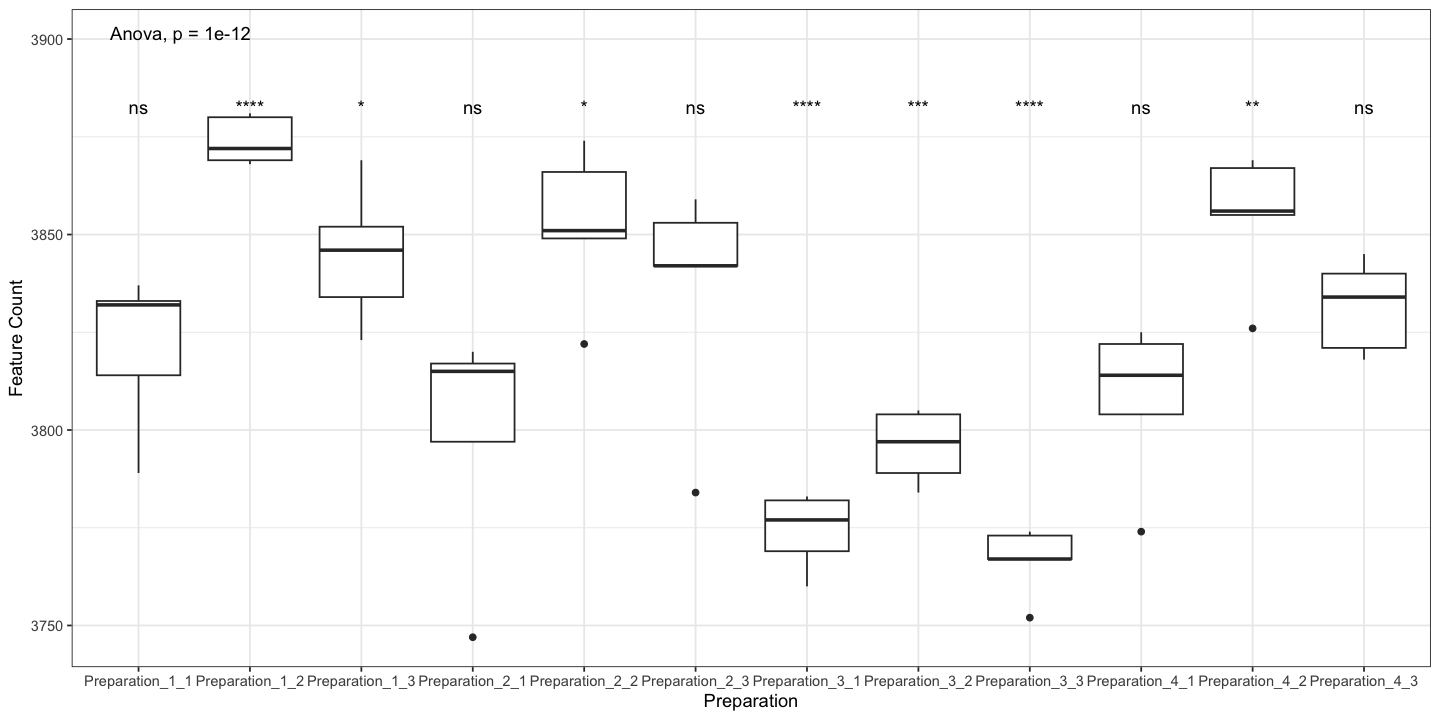

In [93]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 3900)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = ".all.") +
  xlab("Preparation") +
  ylab("Feature Count") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

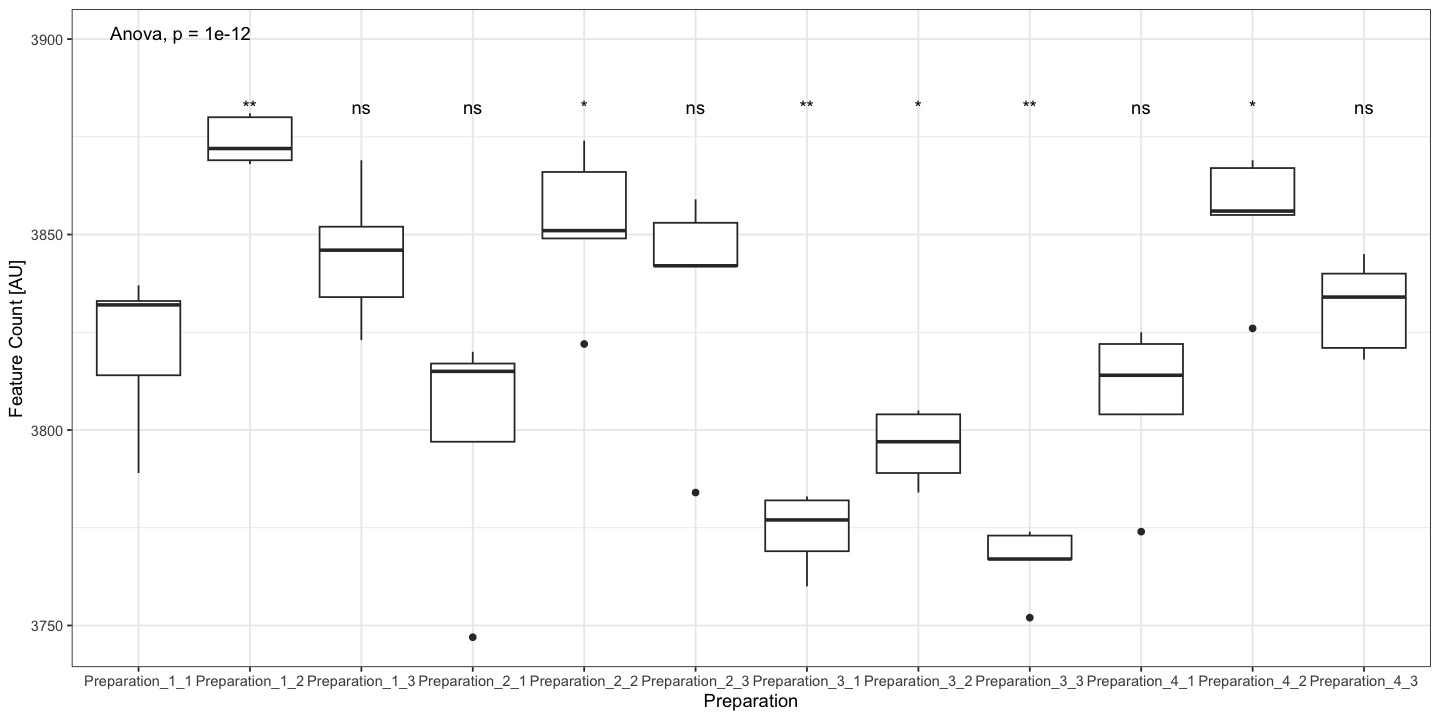

In [94]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 3900)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "Preparation_1_1") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

In [95]:
## Export Feature Count Table
Peaknumber_Results <- as.data.frame(count)
colnames(Peaknumber_Results) <- "Feature_count"
Peaknumber_Results$Sample <- rownames(count)
write.csv(Peaknumber_Results, "Feature_Count.csv")

# Feature Count CV<20

In [96]:
Preparation_1_1 <- results[,results$sample_group == "Preparation_1_1"] %>%
               assay("raw")
cv <- apply(Preparation_1_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_1_cv <- cbind(Preparation_1_1,c(cv))
Preparation_1_1_cv20 <- Preparation_1_1_cv[which(cv <= 20),]
Preparation_1_1_cv20 <- nrow(Preparation_1_1_cv20)

Preparation_1_2 <- results[,results$sample_group == "Preparation_1_2"] %>%
               assay("raw")
cv <- apply(Preparation_1_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_2_cv <- cbind(Preparation_1_2,c(cv))
Preparation_1_2_cv20 <- Preparation_1_2_cv[which(cv <= 20),]
Preparation_1_2_cv20 <-nrow(Preparation_1_2_cv20)
            
Preparation_1_3 <- results[,results$sample_group == "Preparation_1_3"] %>%
               assay("raw")
cv <- apply(Preparation_1_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_3_cv <- cbind(Preparation_1_3,c(cv))
Preparation_1_3_cv20 <- Preparation_1_3_cv[which(cv <= 20),]
Preparation_1_3_cv20 <- nrow(Preparation_1_3_cv20)
            
Preparation_2_1 <- results[,results$sample_group == "Preparation_2_1"] %>%
               assay("raw")
cv <- apply(Preparation_2_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_1_cv <- cbind(Preparation_2_1,c(cv))
Preparation_2_1_cv20 <- Preparation_2_1_cv[which(cv <= 20),]
Preparation_2_1_cv20 <- nrow(Preparation_2_1_cv20)
            
Preparation_2_2 <- results[,results$sample_group == "Preparation_2_2"] %>%
               assay("raw")
cv <- apply(Preparation_2_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_2_cv <- cbind(Preparation_2_2,c(cv))
Preparation_2_2_cv20 <- Preparation_2_2_cv[which(cv <= 20),]
Preparation_2_2_cv20 <- nrow(Preparation_2_2_cv20)
            
Preparation_2_3 <- results[,results$sample_group == "Preparation_2_3"] %>%
               assay("raw")
cv <- apply(Preparation_2_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_3_cv <- cbind(Preparation_2_3,c(cv))
Preparation_2_3_cv20 <- Preparation_2_3_cv[which(cv <= 20),]
Preparation_2_3_cv20 <- nrow(Preparation_2_3_cv20)
            
Preparation_3_1 <- results[,results$sample_group == "Preparation_3_1"] %>%
               assay("raw")
cv <- apply(Preparation_3_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_1_cv <- cbind(Preparation_3_1,c(cv))
Preparation_3_1_cv20 <- Preparation_3_1_cv[which(cv <= 20),]
Preparation_3_1_cv20 <- nrow(Preparation_3_1_cv20)
            
Preparation_3_2 <- results[,results$sample_group == "Preparation_3_2"] %>%
               assay("raw")
cv <- apply(Preparation_3_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_2_cv <- cbind(Preparation_3_2,c(cv))
Preparation_3_2_cv20 <- Preparation_3_2_cv[which(cv <= 20),]
Preparation_3_2_cv20 <- nrow(Preparation_3_2_cv20)
            
Preparation_3_3 <- results[,results$sample_group == "Preparation_3_3"] %>%
               assay("raw")
cv <- apply(Preparation_3_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_3_cv <- cbind(Preparation_3_3,c(cv))
Preparation_3_3_cv20 <- Preparation_3_3_cv[which(cv <= 20),]
Preparation_3_3_cv20 <- nrow(Preparation_3_3_cv20)
            
Preparation_4_1 <- results[,results$sample_group == "Preparation_4_1"] %>%
               assay("raw")
cv <- apply(Preparation_4_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_1_cv <- cbind(Preparation_4_1,c(cv))
Preparation_4_1_cv20 <- Preparation_4_1_cv[which(cv <= 20),]
Preparation_4_1_cv20 <- nrow(Preparation_4_1_cv20)  
            
Preparation_4_2 <- results[,results$sample_group == "Preparation_4_2"] %>%
               assay("raw")
cv <- apply(Preparation_4_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_2_cv <- cbind(Preparation_4_2,c(cv))
Preparation_4_2_cv20 <- Preparation_4_2_cv[which(cv <= 20),]
Preparation_4_2_cv20 <- nrow(Preparation_4_2_cv20) 
            
Preparation_4_3 <- results[,results$sample_group == "Preparation_4_3"] %>%
               assay("raw")
cv <- apply(Preparation_4_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_3_cv <- cbind(Preparation_4_3,c(cv))
Preparation_4_3_cv20 <- Preparation_4_3_cv[which(cv <= 20),]
Preparation_4_3_cv20 <- nrow(Preparation_4_3_cv20)

In [97]:
Preparation_CV20 <- c("Preparation_1_1" = Preparation_1_1_cv20, "Preparation_1_2" = Preparation_1_2_cv20,
                   "Preparation_1_3" = Preparation_1_3_cv20, "Preparation_2_1" = Preparation_2_1_cv20, 
                   "Preparation_2_2" = Preparation_2_2_cv20, "Preparation_2_3" = Preparation_2_3_cv20,
                   "Preparation_3_1" = Preparation_3_1_cv20, "Preparation_3_2" = Preparation_3_2_cv20,
                   "Preparation_3_3" = Preparation_3_3_cv20, "Preparation_4_1" = Preparation_4_1_cv20, 
                   "Preparation_4_2" = Preparation_4_2_cv20, "Preparation_4_3" = Preparation_4_3_cv20)
preparation <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                      "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                      "Preparation_4_2", "Preparation_4_3")
Preparation_CV20 <- cbind(Preparation_CV20, c(preparation))
Preparation_CV20 <- as.data.frame(Preparation_CV20)

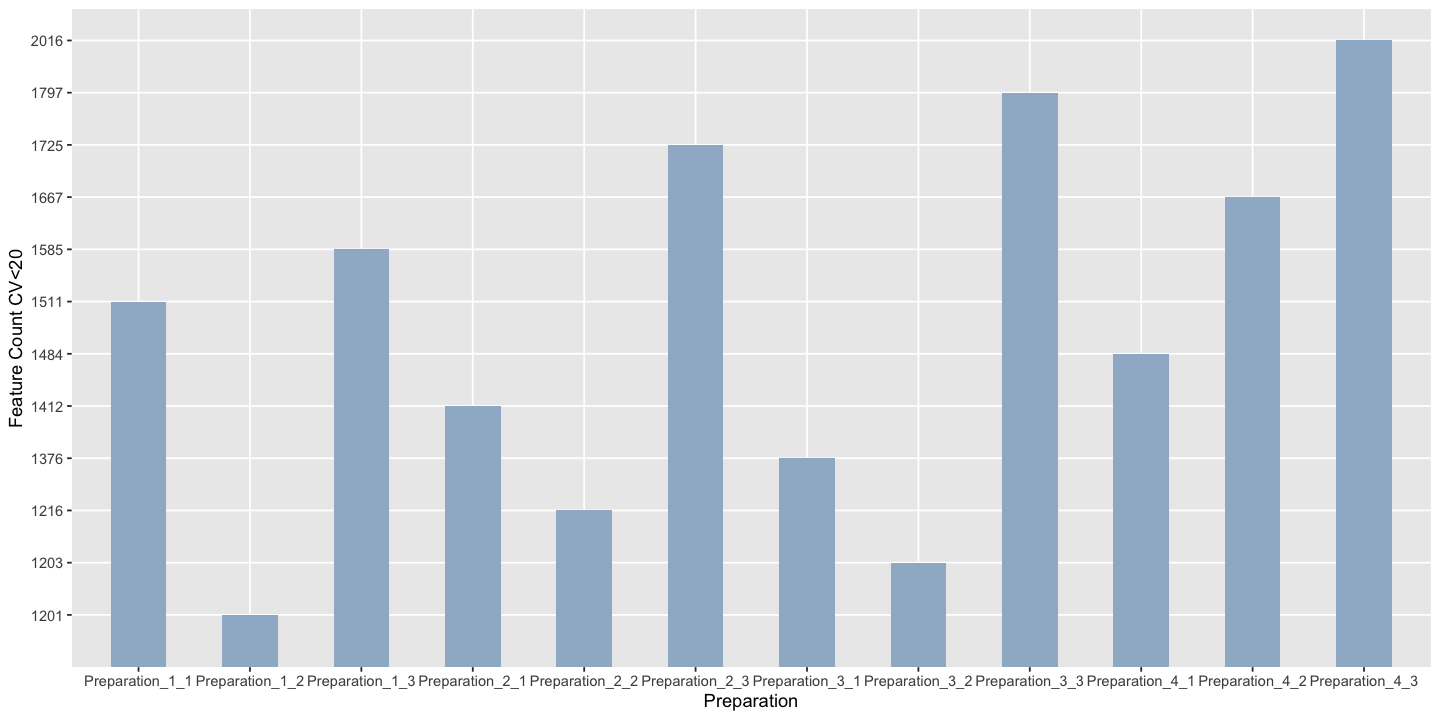

In [98]:
ggplot(Preparation_CV20, aes(preparation, Preparation_CV20))+
geom_col(fill="slategray3", width = 0.5)+
xlab("Preparation") +
ylab("Feature Count CV<20") 

In [99]:
write.csv(Preparation_CV20, "Feature_Count_CV20.csv")

In [100]:
save.image("Rat_Urine_Extraction_ZicHILIC_pos_count.RData")

# Appendix

In [101]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.5.0                devtools_2.4.5             
 [3] usethis_2.1.6               writexl_1.4.2              
 [5] ggrepel_0.9.3               MASS_7.3-58.2              
 [7] caret_6.0-93                lattice_0.20-45            
 [9] Rtsne_0.16                  gplots_3.1.3               
[11] forcats_1.0.0               stringr_1.5.0              
[13] dplyr_1.1.0                 purrr_1.0.1                
[15] readr_2.1.4                 tidyr_1.3.0          